Developed a machine learning model to predict the busyness of taxi zones in Manhattan. The training dataset has both the taxi and subway riderships. both values are combined using natural log transformation to formulate the target_variable according to the formula:


$$
\text{busyness_score} = \ln(\frac{\text{taxi_ridership} \times \left(1 + \text{subway_ridership}\right)}{\text{zone_area}})
$$


Results of the XGBoost Model (average of 5 folds of cross validation):

- Average Mean Squared Error (MSE): 0.17
- Average Root Mean Squared Error (RMSE): 0.41
- Average R-squared (R2): 0.99
- Average Mean Absolute Error (MAE): 0.27
- Relative RMSE (as a percentage of mean): 4.70%
- Relative RMSE (as a percentage of median): 4.49%

This script generates a pickle file `xgboost_busyness_model.pkl` and it has a sample code for running the model to predict a future value, and a color coded map for visualisation!

In [ ]:
import json
from shapely.geometry import shape, Point
import os
# !pip install python-dotenv
from dotenv import load_dotenv
import geopandas as gpd
import pandas as pd
import numpy as np
import seaborn as sns
# !pip install optuna
import optuna
# !pip install folium
import folium
from folium.plugins import HeatMap
from sklearn.model_selection import train_test_split, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import pickle
import branca.colormap as cm
import seaborn as sns


In [8]:
cwd = os.getcwd()
cwd
busyness_df = pd.read_csv('../datasets/taxi_subway_zones_df.csv')


In [9]:
busyness_df.head()

,transit_timestamp,zone_id,taxi_ridership,subway_ridership,subway_station_present,zone_area_m2
0,2022-02-01 00:00:00,4,20,0,False,1.740161e+06
1,2022-02-01 00:00:00,12,1,0,False,2.365054e+05
2,2022-02-01 00:00:00,13,23,0,False,1.068199e+06
3,2022-02-01 00:00:00,24,20,25,True,9.145472e+05
4,2022-02-01 00:00:00,41,32,154,True,3.120089e+06


In [10]:
busyness_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1167176 entries, 0 to 1167175
Data columns (total 6 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   transit_timestamp       1167176 non-null  object 
 1   zone_id                 1167176 non-null  int64  
 2   taxi_ridership          1167176 non-null  int64  
 3   subway_ridership        1167176 non-null  int64  
 4   subway_station_present  1167176 non-null  bool   
 5   zone_area_m2            1167136 non-null  float64
dtypes: bool(1), float64(1), int64(3), object(1)
memory usage: 45.6+ MB


In [11]:
#add a total ridership column.
busyness_df['total_ridership'] = busyness_df['taxi_ridership'] + busyness_df['subway_ridership']
busyness_df = busyness_df.drop(['taxi_ridership', "subway_ridership", "zone_area_m2"], axis=1)

In [12]:
# Convert "transit_timestamp" to datetime to the nearest hour
busyness_df['transit_timestamp'] = pd.to_datetime(busyness_df['transit_timestamp'])

# Display the DataFrame with the correct format for "transit_timestamp"
busyness_df['transit_timestamp'] = busyness_df['transit_timestamp'].dt.round('h')


In [17]:
# Calculate the percentiles for total_ridership
busyness_df['ridership_percentile'] = 100*(busyness_df['total_ridership'].rank(pct=True))

# Log transform the percentiles
busyness_df['log_ridership_percentile'] = np.log1p(busyness_df['ridership_percentile'])

busyness_df['log_ridership'] = np.log1p(busyness_df['total_ridership'])  # using log1p to handle zero values

In [14]:
""" 
New Years Day
Martin L King's Birthday ( 3rd Monday in January )
President’s Day ( 3rd Monday in February )
Memorial Day ( Last Monday in May )
Juneteenth (June 19th)
Independence Day ( July 4 )
Labor Day ( 1st Monday in September )
Columbus Day ( 2nd Monday in October )
Veteran’s Day ( November 11 )
Thanksgiving Day ( 4th Thursday in November )
Christmas Day ( December 25 )
New Years Eve Day
"""

def is_holiday(date):
    holidays = {
        "New Year's Day": (1, 1),
        "Martin Luther King Jr. Day": (1, 'third', 'Monday'),
        "Presidents' Day": (2, 'third', 'Monday'),
        "Memorial Day": (5, 'last', 'Monday'),
        "Juneteenth": (6, 19),
        "Independence Day": (7, 4),
        "Labor Day": (9, 'first', 'Monday'),
        "Columbus Day": (10, 'second', 'Monday'),
        "Veterans Day": (11, 11),
        "Thanksgiving Day": (11, 'fourth', 'Thursday'),
        "Christmas Day": (12, 25),
        "New Year's Eve": (12, 31)
    }
    
    for holiday, date_info in holidays.items():
        if len(date_info) == 2:
            month, day = date_info
            if date.month == month and date.day == day:
                return True
        elif len(date_info) == 3:
            month, occurrence, day_name = date_info
            if date.month == month and date.strftime('%A') == day_name:
                if occurrence == 'first' and date.day <= 7:
                    return True
                elif occurrence == 'second' and 8 <= date.day <= 14:
                    return True
                elif occurrence == 'third' and 15 <= date.day <= 21:
                    return True
                elif occurrence == 'fourth' and 22 <= date.day <= 28:
                    return True
                elif occurrence == 'last' and date.day >= 25:
                    return True
    return False

busyness_df['is_holiday'] = busyness_df['transit_timestamp'].apply(is_holiday)


In [18]:
busyness_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1167176 entries, 0 to 1167175
Data columns (total 8 columns):
 #   Column                    Non-Null Count    Dtype         
---  ------                    --------------    -----         
 0   transit_timestamp         1167176 non-null  datetime64[ns]
 1   zone_id                   1167176 non-null  int64         
 2   subway_station_present    1167176 non-null  bool          
 3   total_ridership           1167176 non-null  int64         
 4   ridership_percentile      1167176 non-null  float64       
 5   log_ridership_percentile  1167176 non-null  float64       
 6   log_ridership             1167176 non-null  float64       
 7   is_holiday                1167176 non-null  bool          
dtypes: bool(2), datetime64[ns](1), float64(3), int64(2)
memory usage: 55.7 MB


In [19]:
#preview the busyness_df
busyness_df.head(1000)

,transit_timestamp,zone_id,subway_station_present,total_ridership,ridership_percentile,log_ridership_percentile,log_ridership,is_holiday
0,2022-02-01 00:00:00,4,False,20,6.431721,2.005757,3.044522,False
1,2022-02-01 00:00:00,12,False,1,0.528455,0.424257,0.693147,False
2,2022-02-01 00:00:00,13,False,23,7.176296,2.101239,3.178054,False
3,2022-02-01 00:00:00,24,True,45,11.923823,2.559072,3.828641,False
4,2022-02-01 00:00:00,41,True,186,30.418206,3.447388,5.231109,False
...,...,...,...,...,...,...,...,...
995,2022-02-01 16:00:00,158,False,84,18.570807,2.974039,4.442651,False
996,2022-02-01 16:00:00,161,True,5429,95.612830,4.570712,8.599694,False
997,2022-02-01 16:00:00,162,True,4407,93.675033,4.550450,8.391176,False
998,2022-02-01 16:00:00,163,True,2007,81.076333,4.407650,7.604894,False


In [20]:
busyness_df['hour'] = busyness_df['transit_timestamp'].dt.hour
busyness_df['day'] = busyness_df['transit_timestamp'].dt.dayofweek
busyness_df['week'] = busyness_df['transit_timestamp'].dt.isocalendar().week
busyness_df['month'] = busyness_df['transit_timestamp'].dt.month - 1  # Convert to 0-11 for Jan-Dec
busyness_df['day_of_month'] = busyness_df['transit_timestamp'].dt.day

Monday: 0, Tuesday: 1, Wednesday: 2, Thursday: 3, Friday: 4, Saturday: 5, Sunday: 6

January: 1, February: 2, March: 3, April: 4, May: 5, June: 6, July: 7, August: 8, September: 9, October: 10, November: 11, December: 12

Benefits of Transforming to Percentiles
Robustness to Outliers: Percentiles can mitigate the influence of extreme values - transform skewed data into a uniform distribution, which can be beneficial for ML algorithms.

In [21]:
busyness_df.head(1000)

,transit_timestamp,zone_id,subway_station_present,total_ridership,ridership_percentile,log_ridership_percentile,log_ridership,is_holiday,hour,day,week,month,day_of_month
0,2022-02-01 00:00:00,4,False,20,6.431721,2.005757,3.044522,False,0,1,5,1,1
1,2022-02-01 00:00:00,12,False,1,0.528455,0.424257,0.693147,False,0,1,5,1,1
2,2022-02-01 00:00:00,13,False,23,7.176296,2.101239,3.178054,False,0,1,5,1,1
3,2022-02-01 00:00:00,24,True,45,11.923823,2.559072,3.828641,False,0,1,5,1,1
4,2022-02-01 00:00:00,41,True,186,30.418206,3.447388,5.231109,False,0,1,5,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,2022-02-01 16:00:00,158,False,84,18.570807,2.974039,4.442651,False,16,1,5,1,1
996,2022-02-01 16:00:00,161,True,5429,95.612830,4.570712,8.599694,False,16,1,5,1,1
997,2022-02-01 16:00:00,162,True,4407,93.675033,4.550450,8.391176,False,16,1,5,1,1
998,2022-02-01 16:00:00,163,True,2007,81.076333,4.407650,7.604894,False,16,1,5,1,1


Text(0, 0.5, 'Frequency')

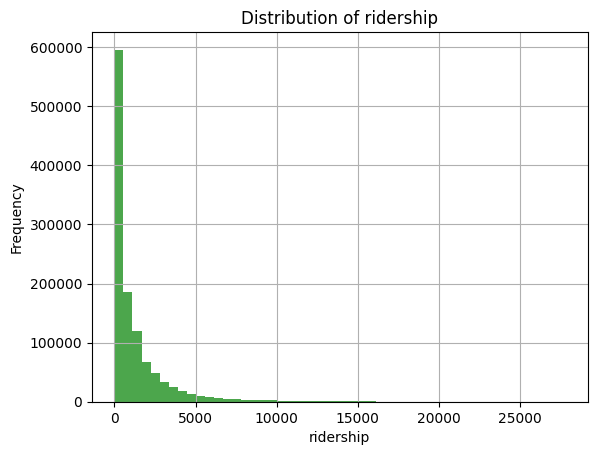

In [23]:
# Plotting the distribution of log-transformed subway ridership with imputed values
plt.hist(busyness_df['total_ridership'], bins=50, color='green', alpha=0.7)
plt.title('Distribution of ridership')
plt.xlabel('ridership')
plt.grid(True)
plt.ylabel('Frequency')

- The right-skewed distribution can cause issues with many machine learning algorithms that assume normality. Log transformation can help in normalizing the distribution, stabilize the variance, reducing heteroscedasticity (i.e., the variability of the data is not constant across the range), helping in linearizing non-linear relationships, and reduces the impact of outliers by bringing extreme values closer to the main body of data.

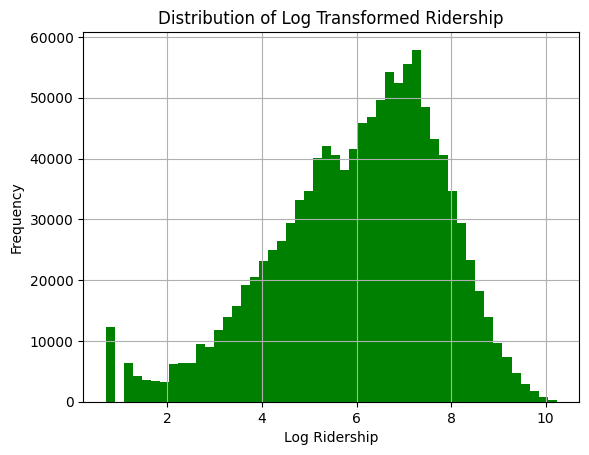

In [24]:
plt.hist(busyness_df['log_ridership'], bins=50, color='green')
plt.title('Distribution of Log Transformed Ridership')
plt.xlabel('Log Ridership')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

Text(0, 0.5, 'Frequency')

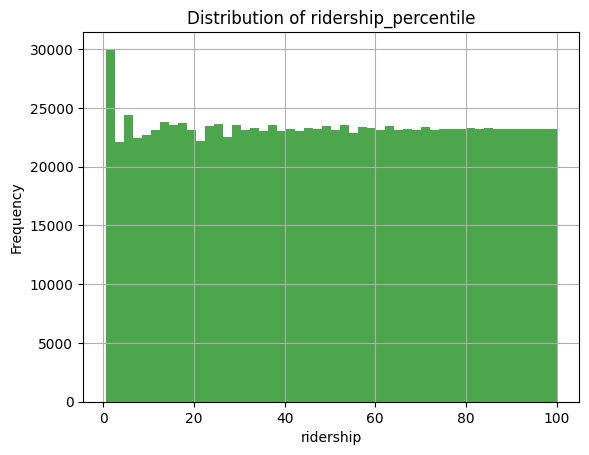

In [25]:
plt.hist(busyness_df['ridership_percentile'], bins=50, color='green', alpha=0.7)
plt.title('Distribution of ridership_percentile')
plt.xlabel('ridership')
plt.grid(True)
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

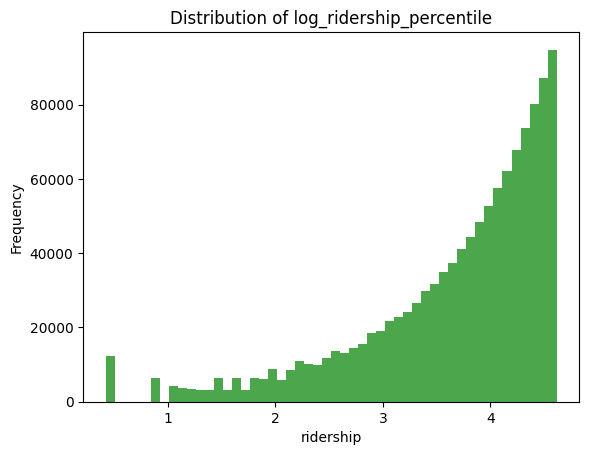

In [26]:
plt.hist(busyness_df['log_ridership_percentile'], bins=50, color='green', alpha=0.7)
plt.title('Distribution of log_ridership_percentile')
plt.xlabel('ridership')
plt.ylabel('Frequency')

In [27]:
# Create time-based features
busyness_df['hour'] = busyness_df['transit_timestamp'].dt.hour
busyness_df['day'] = busyness_df['transit_timestamp'].dt.day
busyness_df['weekday'] = busyness_df['transit_timestamp'].dt.weekday
busyness_df['month'] = busyness_df['transit_timestamp'].dt.month
busyness_df['year'] = busyness_df['transit_timestamp'].dt.year
busyness_df['week'] = busyness_df['transit_timestamp'].dt.isocalendar().week
busyness_df['is_weekend'] = busyness_df['weekday'] >= 5
busyness_df['is_rush_hour'] = busyness_df['hour'].isin([7, 8, 9, 16, 17, 18, 19]) & ~busyness_df['is_weekend']

# Define the range of years in the dataset
min_year = busyness_df['year'].min()
max_year = busyness_df['year'].max()

# Create cyclic features for hour, month, week, and year
busyness_df['hour_sin'] = np.sin(2 * np.pi * busyness_df['hour'] / 24)
busyness_df['hour_cos'] = np.cos(2 * np.pi * busyness_df['hour'] / 24)
busyness_df['day_sin'] = np.sin(2 * np.pi * busyness_df['day'] / 31)
busyness_df['day_cos'] = np.cos(2 * np.pi * busyness_df['day'] / 31)
busyness_df['weekday_sin'] = np.sin(2 * np.pi * busyness_df['weekday'] / 7)
busyness_df['weekday_cos'] = np.cos(2 * np.pi * busyness_df['weekday'] / 7)
busyness_df['month_sin'] = np.sin(2 * np.pi * busyness_df['month'] / 12)
busyness_df['month_cos'] = np.cos(2 * np.pi * busyness_df['month'] / 12)
busyness_df['week_sin'] = np.sin(2 * np.pi * busyness_df['week'] / 52)
busyness_df['week_cos'] = np.cos(2 * np.pi * busyness_df['week'] / 52)
busyness_df['year_sin'] = np.sin(2 * np.pi * (busyness_df['year'] - min_year) / (max_year - min_year + 1))
busyness_df['year_cos'] = np.cos(2 * np.pi * (busyness_df['year'] - min_year) / (max_year - min_year + 1))

C:\Users\35385\AppData\Local\Temp\ipykernel_39404\1237064923.py:20: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  busyness_df['rolling_mean_24h'].fillna(method='ffill', inplace=True)
C:\Users\35385\AppData\Local\Temp\ipykernel_39404\1237064923.py:20: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  busyness_df['rolling_mean_24h'].fillna(method='ffill', inplace=True)
C:\Users\35385\AppData\Local\Temp\ipykernel_39404\1237064923.py:21: FutureWar

total_ridership           1.000000
is_rush_hour              0.302730
subway_station_present    0.251214
weekday_sin               0.102260
year_sin                  0.016768
month_cos                 0.008313
week_cos                  0.005642
day_sin                   0.004091
month_sin                -0.007087
week_sin                 -0.009733
day_cos                  -0.010387
year_cos                 -0.034985
is_holiday               -0.039128
weekday_cos              -0.045626
is_weekend               -0.109249
hour_cos                 -0.228161
hour_sin                 -0.297983
Name: total_ridership, dtype: float64


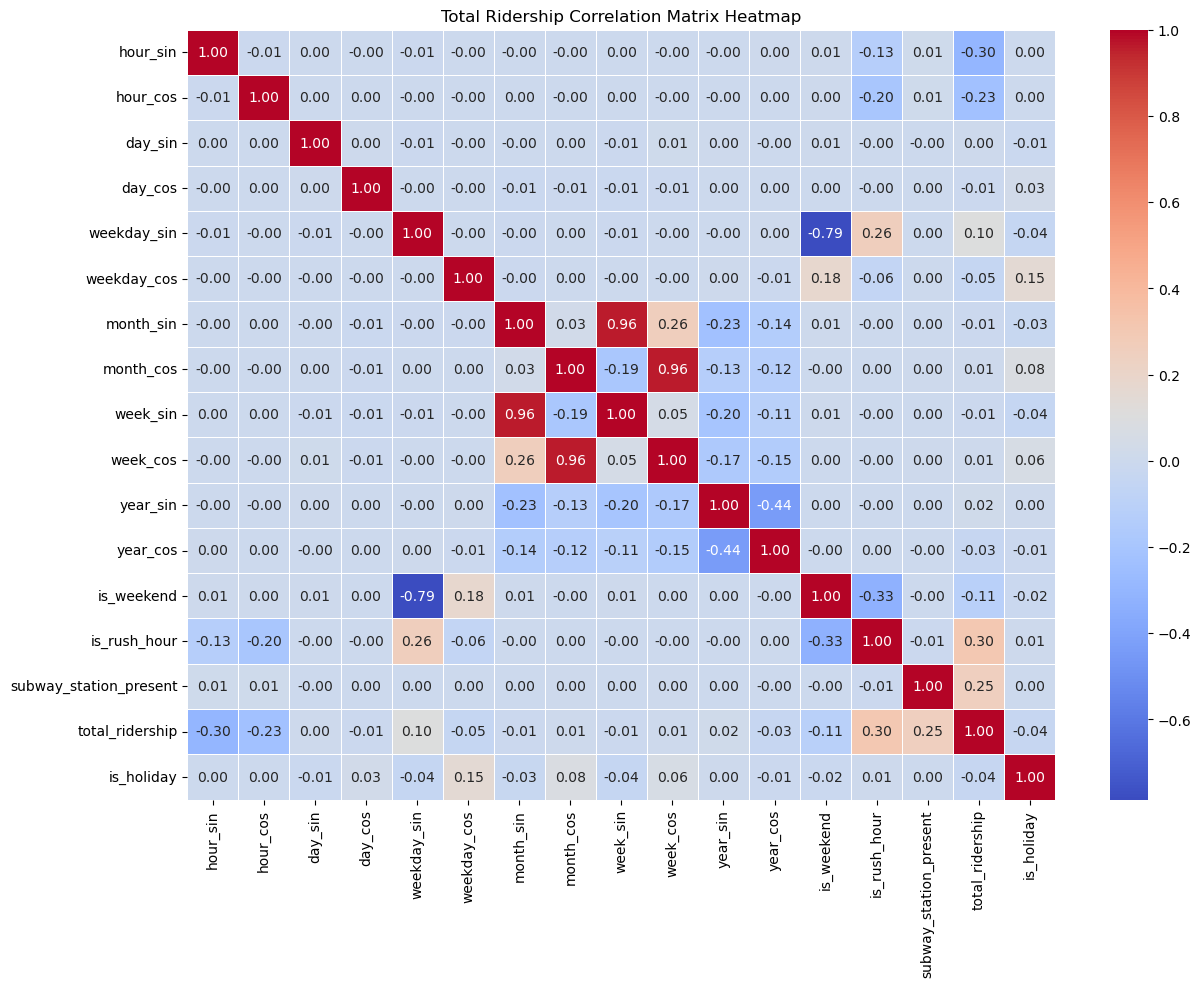

In [ ]:
"""
Total Ridership calculations
"""

# Calculate rolling averages and lags on the original data

# Create rolling and lagged features with grouping by 'zone_id'
busyness_df['rolling_mean_24h'] = busyness_df.groupby('zone_id')['total_ridership'].transform(lambda x: x.shift(1).rolling(window=24).mean())
busyness_df['rolling_std_24h'] = busyness_df.groupby('zone_id')['total_ridership'].transform(lambda x: x.shift(1).rolling(window=24).std())
busyness_df['rolling_mean_7d'] = busyness_df.groupby('zone_id')['total_ridership'].transform(lambda x: x.shift(1).rolling(window=24*7).mean())
busyness_df['rolling_std_7d'] = busyness_df.groupby('zone_id')['total_ridership'].transform(lambda x: x.shift(1).rolling(window=24*7).std())

# Lagged features with grouping by 'zone_id'
busyness_df['lag_1h'] = busyness_df.groupby('zone_id')['total_ridership'].transform(lambda x: x.shift(1))
busyness_df['lag_24h'] = busyness_df.groupby('zone_id')['total_ridership'].transform(lambda x: x.shift(24))
busyness_df['lag_7d'] = busyness_df.groupby('zone_id')['total_ridership'].transform(lambda x: x.shift(24*7))

#fill NaN values with the the last observed value

busyness_df['rolling_mean_24h'].fillna(method='ffill', inplace=True)
busyness_df['rolling_std_24h'].fillna(method='ffill', inplace=True)
busyness_df['rolling_mean_7d'].fillna(method='ffill', inplace=True)
busyness_df['rolling_std_7d'].fillna(method='ffill', inplace=True)

busyness_df['lag_1h'].fillna(method='ffill', inplace=True)
busyness_df['lag_24h'].fillna(method='ffill', inplace=True)
busyness_df['lag_7d'].fillna(method='ffill', inplace=True)


# Apply log transformation to these features if necessary
busyness_df['log_rolling_mean_24h'] = np.log1p(busyness_df['rolling_mean_24h'])
busyness_df['log_rolling_std_24h'] = np.log1p(busyness_df['rolling_std_24h'])
busyness_df['log_rolling_mean_7d'] = np.log1p(busyness_df['rolling_mean_7d'])
busyness_df['log_rolling_std_7d'] = np.log1p(busyness_df['rolling_std_7d'])
busyness_df['log_lag_1h'] = np.log1p(busyness_df['lag_1h'])
busyness_df['log_lag_24h'] = np.log1p(busyness_df['lag_24h'])
busyness_df['log_lag_7d'] = np.log1p(busyness_df['lag_7d'])

# Ensure that the dataframe is in chronological order
busyness_df = busyness_df.sort_values(by='transit_timestamp').reset_index(drop=True)

# List of features for correlation matrix
features_corr = [
    'hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'weekday_sin', 'weekday_cos', 'month_sin', 'month_cos', 'week_sin', 'week_cos', 'year_sin', 'year_cos',
    'is_weekend', 'is_rush_hour', 'subway_station_present', 'total_ridership', 'is_holiday'
]

# Calculate the correlation matrix
correlation_matrix = busyness_df[features_corr].corr()

# Extract the correlation of each feature with the target variable
correlation_with_target = correlation_matrix['total_ridership'].sort_values(ascending=False)

# Display the correlation values with the target variable
print(correlation_with_target)

# Plot the correlation matrix heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True, linewidths=.5)
plt.title('Total Ridership Correlation Matrix Heatmap')
plt.show()


In [ ]:
busyness_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1167176 entries, 0 to 1167175
Data columns (total 43 columns):
 #   Column                    Non-Null Count    Dtype         
---  ------                    --------------    -----         
 0   transit_timestamp         1167176 non-null  datetime64[ns]
 1   zone_id                   1167176 non-null  int64         
 2   subway_station_present    1167176 non-null  bool          
 3   total_ridership           1167176 non-null  int64         
 4   ridership_percentile      1167176 non-null  float64       
 5   log_ridership_percentile  1167176 non-null  float64       
 6   log_ridership             1167176 non-null  float64       
 7   is_holiday                1167176 non-null  bool          
 8   hour                      1167176 non-null  int32         
 9   day                       1167176 non-null  int32         
 10  week                      1167176 non-null  UInt32        
 11  month                     1167176 non-null  int32 

C:\Users\35385\AppData\Local\Temp\ipykernel_39404\105369145.py:20: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  busyness_df['rolling_mean_24h'].fillna(method='ffill', inplace=True)
C:\Users\35385\AppData\Local\Temp\ipykernel_39404\105369145.py:20: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  busyness_df['rolling_mean_24h'].fillna(method='ffill', inplace=True)
C:\Users\35385\AppData\Local\Temp\ipykernel_39404\105369145.py:21: FutureWarnin

ridership_percentile      1.000000
subway_station_present    0.476513
is_rush_hour              0.291933
weekday_sin               0.052952
year_sin                  0.013236
day_sin                   0.004832
month_cos                -0.004921
month_sin                -0.006371
week_sin                 -0.006595
week_cos                 -0.006874
day_cos                  -0.012354
year_cos                 -0.017806
is_holiday               -0.039253
weekday_cos              -0.051607
is_weekend               -0.065544
hour_cos                 -0.380222
hour_sin                 -0.400495
Name: ridership_percentile, dtype: float64


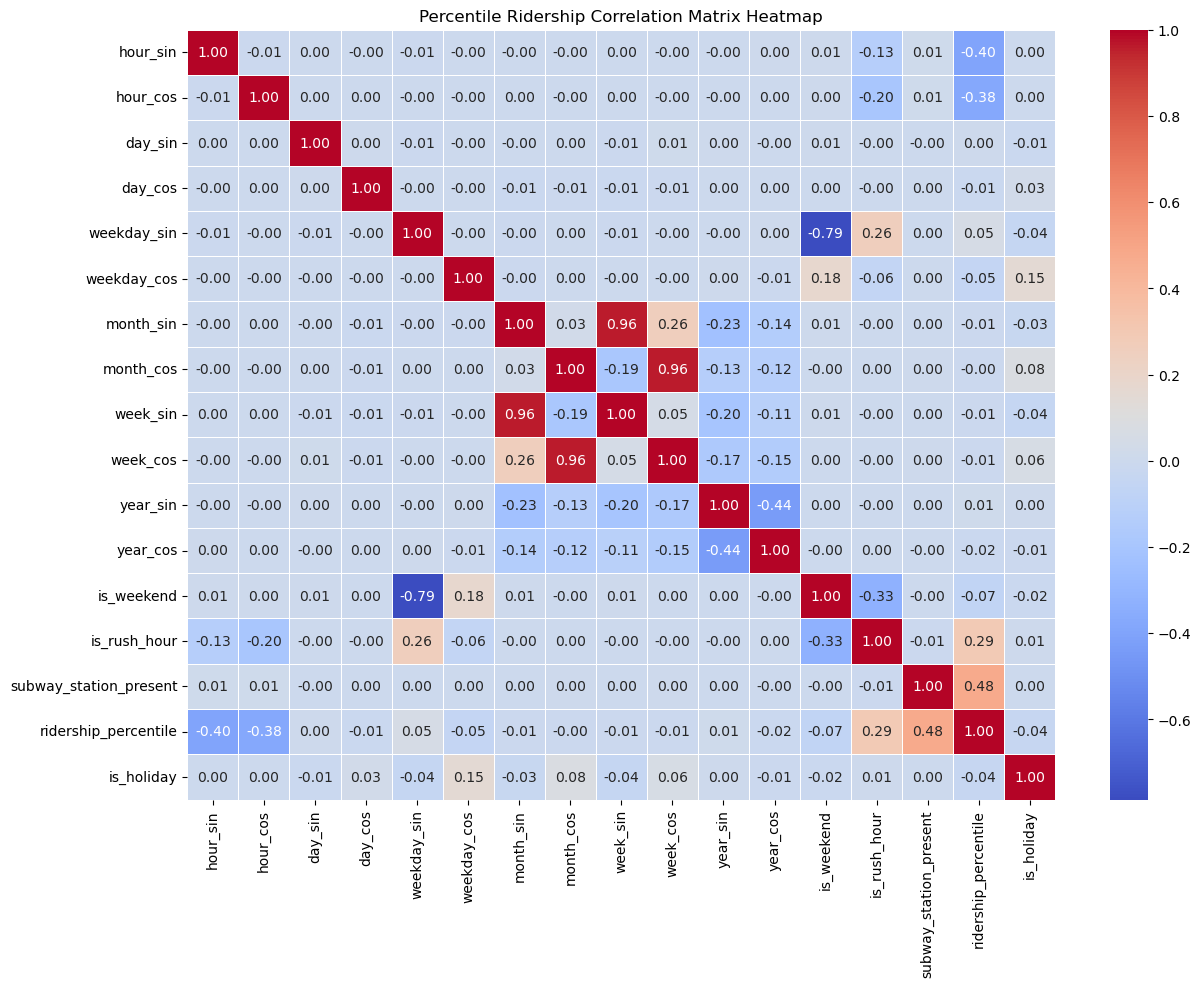

In [ ]:
"""
Percentile Ridership calculations
"""

# Calculate rolling averages and lags on the original data

# Create rolling and lagged features with grouping by 'zone_id'
busyness_df['rolling_mean_24h'] = busyness_df.groupby('zone_id')['ridership_percentile'].transform(lambda x: x.shift(1).rolling(window=24).mean())
busyness_df['rolling_std_24h'] = busyness_df.groupby('zone_id')['ridership_percentile'].transform(lambda x: x.shift(1).rolling(window=24).std())
busyness_df['rolling_mean_7d'] = busyness_df.groupby('zone_id')['ridership_percentile'].transform(lambda x: x.shift(1).rolling(window=24*7).mean())
busyness_df['rolling_std_7d'] = busyness_df.groupby('zone_id')['ridership_percentile'].transform(lambda x: x.shift(1).rolling(window=24*7).std())

# Lagged features with grouping by 'zone_id'
busyness_df['lag_1h'] = busyness_df.groupby('zone_id')['ridership_percentile'].transform(lambda x: x.shift(1))
busyness_df['lag_24h'] = busyness_df.groupby('zone_id')['ridership_percentile'].transform(lambda x: x.shift(24))
busyness_df['lag_7d'] = busyness_df.groupby('zone_id')['ridership_percentile'].transform(lambda x: x.shift(24*7))

#fill NaN values with the the last observed value

busyness_df['rolling_mean_24h'].fillna(method='ffill', inplace=True)
busyness_df['rolling_std_24h'].fillna(method='ffill', inplace=True)
busyness_df['rolling_mean_7d'].fillna(method='ffill', inplace=True)
busyness_df['rolling_std_7d'].fillna(method='ffill', inplace=True)

busyness_df['lag_1h'].fillna(method='ffill', inplace=True)
busyness_df['lag_24h'].fillna(method='ffill', inplace=True)
busyness_df['lag_7d'].fillna(method='ffill', inplace=True)


# Apply log transformation to these features if necessary
busyness_df['log_rolling_mean_24h'] = np.log1p(busyness_df['rolling_mean_24h'])
busyness_df['log_rolling_std_24h'] = np.log1p(busyness_df['rolling_std_24h'])
busyness_df['log_rolling_mean_7d'] = np.log1p(busyness_df['rolling_mean_7d'])
busyness_df['log_rolling_std_7d'] = np.log1p(busyness_df['rolling_std_7d'])
busyness_df['log_lag_1h'] = np.log1p(busyness_df['lag_1h'])
busyness_df['log_lag_24h'] = np.log1p(busyness_df['lag_24h'])
busyness_df['log_lag_7d'] = np.log1p(busyness_df['lag_7d'])

# Ensure that the dataframe is in chronological order
busyness_df = busyness_df.sort_values(by='transit_timestamp').reset_index(drop=True)

# List of features for correlation matrix
features_corr = [
    'hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'weekday_sin', 'weekday_cos', 'month_sin', 'month_cos', 'week_sin', 'week_cos', 'year_sin', 'year_cos',
    'is_weekend', 'is_rush_hour', 'subway_station_present', 'ridership_percentile', 'is_holiday'
]

# Calculate the correlation matrix
correlation_matrix = busyness_df[features_corr].corr()

# Extract the correlation of each feature with the target variable
correlation_with_target = correlation_matrix['ridership_percentile'].sort_values(ascending=False)

# Display the correlation values with the target variable
print(correlation_with_target)

# Plot the correlation matrix heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True, linewidths=.5)
plt.title('Percentile Ridership Correlation Matrix Heatmap')
plt.show()


C:\Users\35385\AppData\Local\Temp\ipykernel_39404\1576677868.py:20: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  busyness_df['rolling_mean_24h'].fillna(method='ffill', inplace=True)
C:\Users\35385\AppData\Local\Temp\ipykernel_39404\1576677868.py:20: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  busyness_df['rolling_mean_24h'].fillna(method='ffill', inplace=True)
C:\Users\35385\AppData\Local\Temp\ipykernel_39404\1576677868.py:21: FutureWar

log_ridership_percentile    1.000000
subway_station_present      0.491301
is_rush_hour                0.281509
weekday_sin                 0.042430
year_sin                    0.012496
day_sin                     0.004732
month_cos                  -0.006252
week_sin                   -0.006257
month_sin                  -0.006297
week_cos                   -0.008098
day_cos                    -0.012027
year_cos                   -0.015125
is_holiday                 -0.037163
weekday_cos                -0.049774
is_weekend                 -0.054266
hour_cos                   -0.379624
hour_sin                   -0.402391
Name: log_ridership_percentile, dtype: float64


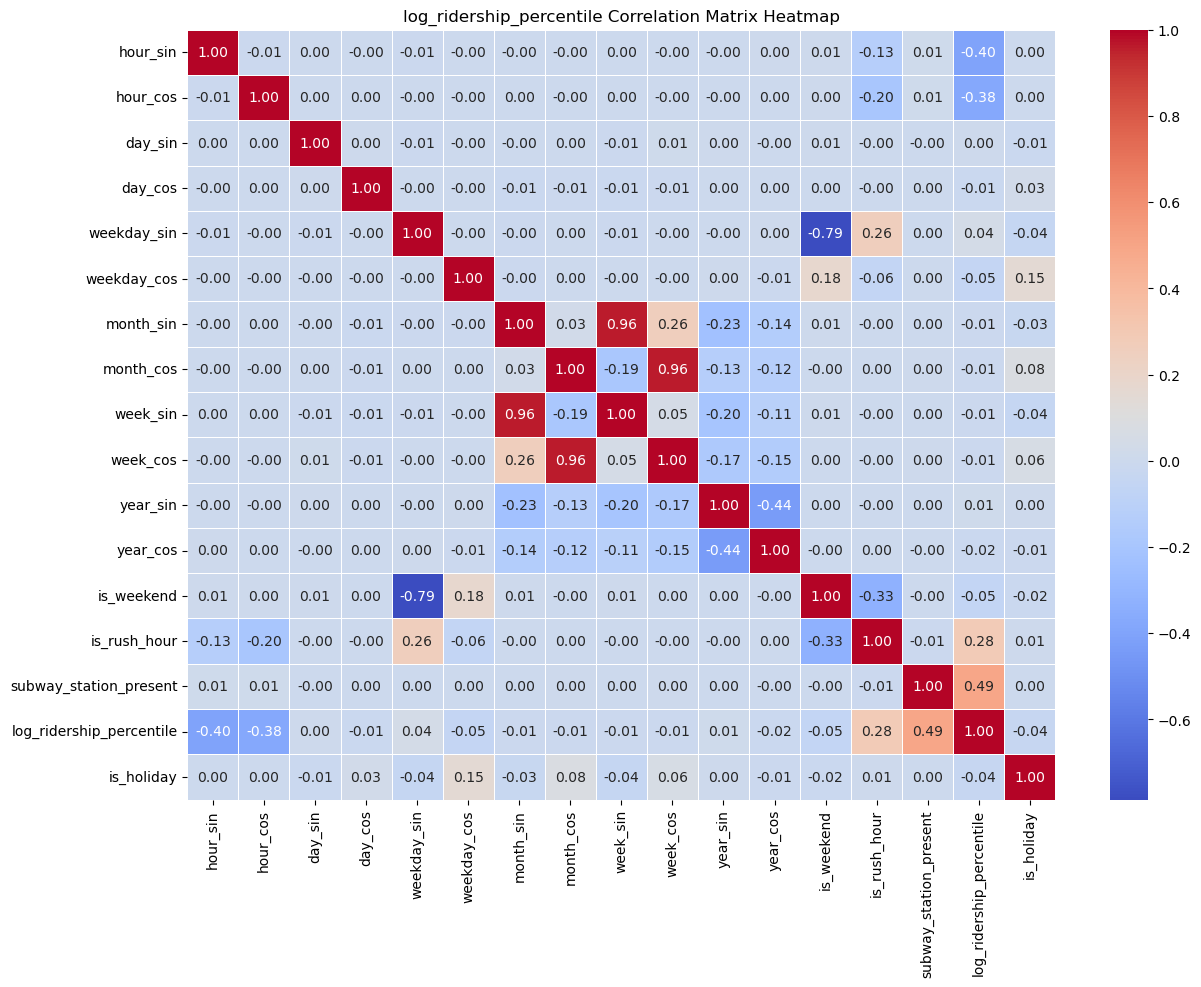

In [ ]:
"""
log_ridership_percentile calculations
"""

# Calculate rolling averages and lags on the original data

# Create rolling and lagged features with grouping by 'zone_id'
busyness_df['rolling_mean_24h'] = busyness_df.groupby('zone_id')['log_ridership_percentile'].transform(lambda x: x.shift(1).rolling(window=24).mean())
busyness_df['rolling_std_24h'] = busyness_df.groupby('zone_id')['log_ridership_percentile'].transform(lambda x: x.shift(1).rolling(window=24).std())
busyness_df['rolling_mean_7d'] = busyness_df.groupby('zone_id')['log_ridership_percentile'].transform(lambda x: x.shift(1).rolling(window=24*7).mean())
busyness_df['rolling_std_7d'] = busyness_df.groupby('zone_id')['log_ridership_percentile'].transform(lambda x: x.shift(1).rolling(window=24*7).std())

# Lagged features with grouping by 'zone_id'
busyness_df['lag_1h'] = busyness_df.groupby('zone_id')['log_ridership_percentile'].transform(lambda x: x.shift(1))
busyness_df['lag_24h'] = busyness_df.groupby('zone_id')['log_ridership_percentile'].transform(lambda x: x.shift(24))
busyness_df['lag_7d'] = busyness_df.groupby('zone_id')['log_ridership_percentile'].transform(lambda x: x.shift(24*7))

#fill NaN values with the the last observed value

busyness_df['rolling_mean_24h'].fillna(method='ffill', inplace=True)
busyness_df['rolling_std_24h'].fillna(method='ffill', inplace=True)
busyness_df['rolling_mean_7d'].fillna(method='ffill', inplace=True)
busyness_df['rolling_std_7d'].fillna(method='ffill', inplace=True)

busyness_df['lag_1h'].fillna(method='ffill', inplace=True)
busyness_df['lag_24h'].fillna(method='ffill', inplace=True)
busyness_df['lag_7d'].fillna(method='ffill', inplace=True)


# Apply log transformation to these features if necessary
busyness_df['log_rolling_mean_24h'] = np.log1p(busyness_df['rolling_mean_24h'])
busyness_df['log_rolling_std_24h'] = np.log1p(busyness_df['rolling_std_24h'])
busyness_df['log_rolling_mean_7d'] = np.log1p(busyness_df['rolling_mean_7d'])
busyness_df['log_rolling_std_7d'] = np.log1p(busyness_df['rolling_std_7d'])
busyness_df['log_lag_1h'] = np.log1p(busyness_df['lag_1h'])
busyness_df['log_lag_24h'] = np.log1p(busyness_df['lag_24h'])
busyness_df['log_lag_7d'] = np.log1p(busyness_df['lag_7d'])

# Ensure that the dataframe is in chronological order
busyness_df = busyness_df.sort_values(by='transit_timestamp').reset_index(drop=True)

# List of features for correlation matrix
features_corr = [
    'hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'weekday_sin', 'weekday_cos', 'month_sin', 'month_cos', 'week_sin', 'week_cos', 'year_sin', 'year_cos',
    'is_weekend', 'is_rush_hour', 'subway_station_present', 'log_ridership_percentile', 'is_holiday'
]

# Calculate the correlation matrix
correlation_matrix = busyness_df[features_corr].corr()

# Extract the correlation of each feature with the target variable
correlation_with_target = correlation_matrix['log_ridership_percentile'].sort_values(ascending=False)

# Display the correlation values with the target variable
print(correlation_with_target)

# Plot the correlation matrix heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True, linewidths=.5)
plt.title('log_ridership_percentile Correlation Matrix Heatmap')
plt.show()


C:\Users\35385\AppData\Local\Temp\ipykernel_39404\3363293225.py:20: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  busyness_df['rolling_mean_24h'].fillna(method='ffill', inplace=True)
C:\Users\35385\AppData\Local\Temp\ipykernel_39404\3363293225.py:20: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  busyness_df['rolling_mean_24h'].fillna(method='ffill', inplace=True)
C:\Users\35385\AppData\Local\Temp\ipykernel_39404\3363293225.py:21: FutureWar

log_ridership             1.000000
subway_station_present    0.513608
is_rush_hour              0.267953
weekday_sin               0.033573
year_sin                  0.012719
day_sin                   0.004400
month_cos                -0.005931
week_sin                 -0.006560
month_sin                -0.006589
week_cos                 -0.007850
day_cos                  -0.011115
year_cos                 -0.015393
is_holiday               -0.033641
is_weekend               -0.044393
weekday_cos              -0.047441
hour_cos                 -0.346939
hour_sin                 -0.385610
Name: log_ridership, dtype: float64


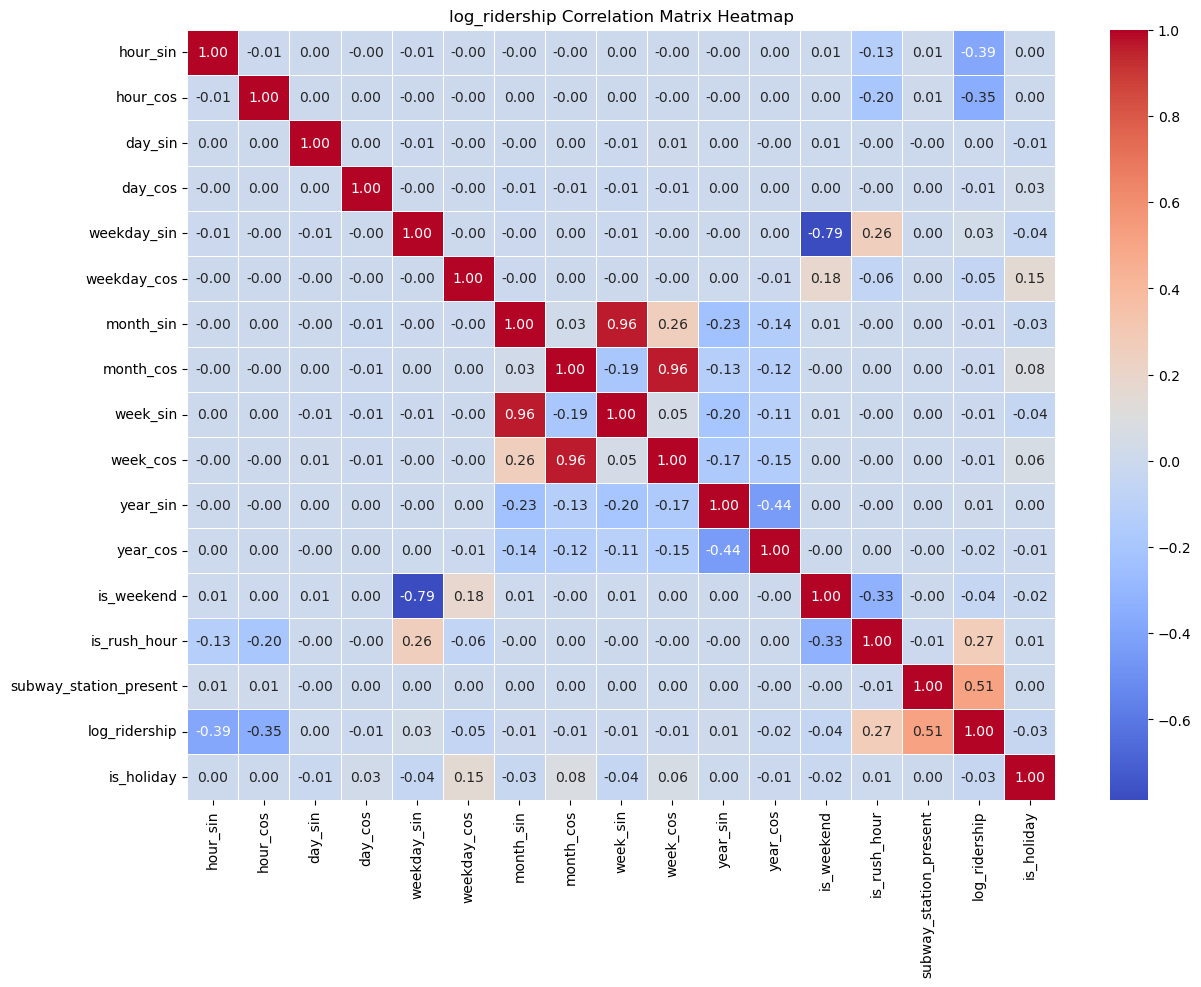

In [ ]:
"""
log_ridership calculations
"""

# Calculate rolling averages and lags on the original data

# Create rolling and lagged features with grouping by 'zone_id'
busyness_df['rolling_mean_24h'] = busyness_df.groupby('zone_id')['log_ridership'].transform(lambda x: x.shift(1).rolling(window=24).mean())
busyness_df['rolling_std_24h'] = busyness_df.groupby('zone_id')['log_ridership'].transform(lambda x: x.shift(1).rolling(window=24).std())
busyness_df['rolling_mean_7d'] = busyness_df.groupby('zone_id')['log_ridership'].transform(lambda x: x.shift(1).rolling(window=24*7).mean())
busyness_df['rolling_std_7d'] = busyness_df.groupby('zone_id')['log_ridership'].transform(lambda x: x.shift(1).rolling(window=24*7).std())

# Lagged features with grouping by 'zone_id'
busyness_df['lag_1h'] = busyness_df.groupby('zone_id')['log_ridership'].transform(lambda x: x.shift(1))
busyness_df['lag_24h'] = busyness_df.groupby('zone_id')['log_ridership'].transform(lambda x: x.shift(24))
busyness_df['lag_7d'] = busyness_df.groupby('zone_id')['log_ridership'].transform(lambda x: x.shift(24*7))

#fill NaN values with the the last observed value

busyness_df['rolling_mean_24h'].fillna(method='ffill', inplace=True)
busyness_df['rolling_std_24h'].fillna(method='ffill', inplace=True)
busyness_df['rolling_mean_7d'].fillna(method='ffill', inplace=True)
busyness_df['rolling_std_7d'].fillna(method='ffill', inplace=True)

busyness_df['lag_1h'].fillna(method='ffill', inplace=True)
busyness_df['lag_24h'].fillna(method='ffill', inplace=True)
busyness_df['lag_7d'].fillna(method='ffill', inplace=True)


# Apply log transformation to these features if necessary
busyness_df['log_rolling_mean_24h'] = np.log1p(busyness_df['rolling_mean_24h'])
busyness_df['log_rolling_std_24h'] = np.log1p(busyness_df['rolling_std_24h'])
busyness_df['log_rolling_mean_7d'] = np.log1p(busyness_df['rolling_mean_7d'])
busyness_df['log_rolling_std_7d'] = np.log1p(busyness_df['rolling_std_7d'])
busyness_df['log_lag_1h'] = np.log1p(busyness_df['lag_1h'])
busyness_df['log_lag_24h'] = np.log1p(busyness_df['lag_24h'])
busyness_df['log_lag_7d'] = np.log1p(busyness_df['lag_7d'])

# Ensure that the dataframe is in chronological order
busyness_df = busyness_df.sort_values(by='transit_timestamp').reset_index(drop=True)

# List of features for correlation matrix
features_corr = [
    'hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'weekday_sin', 'weekday_cos', 'month_sin', 'month_cos', 'week_sin', 'week_cos', 'year_sin', 'year_cos',
    'is_weekend', 'is_rush_hour', 'subway_station_present', 'log_ridership', 'is_holiday'
]

# Calculate the correlation matrix
correlation_matrix = busyness_df[features_corr].corr()

# Extract the correlation of each feature with the target variable
correlation_with_target = correlation_matrix['log_ridership'].sort_values(ascending=False)

# Display the correlation values with the target variable
print(correlation_with_target)

# Plot the correlation matrix heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True, linewidths=.5)
plt.title('log_ridership Correlation Matrix Heatmap')
plt.show()


                          hour_sin  hour_cos   day_sin   day_cos  weekday_sin  \
hour_sin                  1.000000 -0.007178  0.000284 -0.000258    -0.006055   
hour_cos                 -0.007178  1.000000  0.000184  0.000514    -0.003443   
day_sin                   0.000284  0.000184  1.000000  0.002514    -0.006131   
day_cos                  -0.000258  0.000514  0.002514  1.000000    -0.000829   
weekday_sin              -0.006055 -0.003443 -0.006131 -0.000829     1.000000   
weekday_cos              -0.002064 -0.002031 -0.001632 -0.003438    -0.000277   
month_sin                -0.000190  0.000134 -0.004383 -0.013042    -0.004937   
month_cos                -0.001617 -0.000623  0.002338 -0.006299     0.000985   
week_sin                  0.000049  0.000246 -0.010541 -0.013914    -0.005588   
week_cos                 -0.001598 -0.000559  0.013697 -0.007189    -0.001313   
year_sin                 -0.000472 -0.000407  0.003633  0.000606    -0.000286   
year_cos                  0.

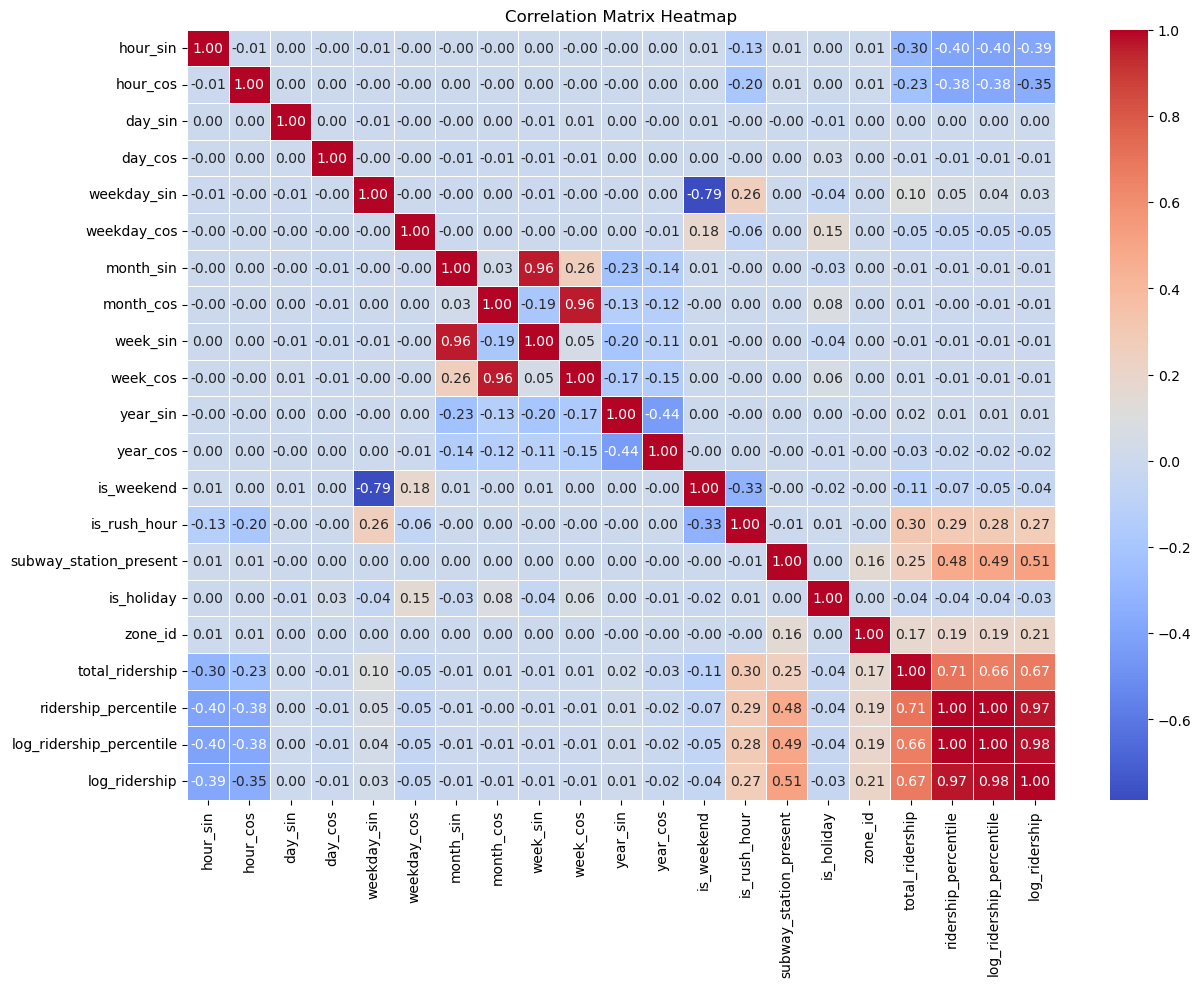

In [ ]:
# Ensure that the dataframe is in chronological order
busyness_df = busyness_df.sort_values(by='transit_timestamp').reset_index(drop=True)

# Define features and target
features = [
    'hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'weekday_sin', 'weekday_cos', 'month_sin', 'month_cos', 'week_sin', 'week_cos', 'year_sin', 'year_cos',
    'is_weekend', 'is_rush_hour', 'subway_station_present', 'is_holiday'
]

# Compute the correlation matrix

all_columns = features + ['zone_id'] + ['total_ridership', 'ridership_percentile', 'log_ridership_percentile', 'log_ridership']
correlation_matrix = busyness_df[all_columns].corr()

# Display the correlation with the target variable
print(correlation_matrix)

plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True, linewidths=.5)
plt.title('Correlation Matrix Heatmap')
plt.show()

In [ ]:
busyness_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1167176 entries, 0 to 1167175
Data columns (total 43 columns):
 #   Column                    Non-Null Count    Dtype         
---  ------                    --------------    -----         
 0   transit_timestamp         1167176 non-null  datetime64[ns]
 1   zone_id                   1167176 non-null  int64         
 2   subway_station_present    1167176 non-null  bool          
 3   total_ridership           1167176 non-null  int64         
 4   ridership_percentile      1167176 non-null  float64       
 5   log_ridership_percentile  1167176 non-null  float64       
 6   log_ridership             1167176 non-null  float64       
 7   is_holiday                1167176 non-null  bool          
 8   hour                      1167176 non-null  int32         
 9   day                       1167176 non-null  int32         
 10  week                      1167176 non-null  UInt32        
 11  month                     1167176 non-null  int32 

In [ ]:
busyness_df.head(229000)

,transit_timestamp,zone_id,subway_station_present,total_ridership,ridership_percentile,log_ridership_percentile,log_ridership,is_holiday,hour,day,...,lag_1h,lag_24h,lag_7d,log_rolling_mean_24h,log_rolling_std_24h,log_rolling_mean_7d,log_rolling_std_7d,log_lag_1h,log_lag_24h,log_lag_7d
0,2022-02-01 00:00:00,4,False,20,0.064317,0.062333,3.044522,False,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2022-02-01 00:00:00,79,True,172,0.290182,0.254783,5.153292,False,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2022-02-01 00:00:00,161,True,680,0.553101,0.440253,6.523562,False,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2022-02-01 00:00:00,162,True,502,0.488711,0.397911,6.220590,False,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2022-02-01 00:00:00,163,True,278,0.378303,0.320853,5.631212,False,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
228995,2022-07-04 14:00:00,143,True,1033,0.652369,0.502210,6.941190,True,14,4,...,6.893656,7.026427,7.325808,1.926368,0.845476,1.976343,0.888530,2.066059,2.082739,2.119360
228996,2022-07-04 14:00:00,144,True,2141,0.823294,0.600645,7.669495,True,14,4,...,7.551187,7.942007,7.747597,2.015495,0.886650,2.044910,0.891343,2.146070,2.190760,2.168779
228997,2022-07-04 14:00:00,148,True,1521,0.749836,0.559522,7.327781,True,14,4,...,7.143618,7.479864,7.737616,2.025915,0.633486,2.061635,0.686814,2.097235,2.137694,2.167637
228998,2022-07-04 14:00:00,151,True,606,0.528164,0.424067,6.408529,True,14,4,...,6.320768,6.364751,6.609349,1.845326,0.752322,1.899971,0.787646,1.990715,1.996705,2.029378


Mean Squared Error/ RMSE - how close a regression line is to a set of data points - average squared error made by the predictions(0)
RSquared - the proportion of variance in the dependent variable that can be explained by independent variables (1)
MAE - measure of the average size of the mistakes in a collection of predictions, without taking their direction into account (0-0.2)

In [ ]:
# features = [
#         'hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'weekday_sin', 'weekday_cos', 'month_sin', 'month_cos', 
#         'week_sin', 'week_cos', 'year_sin', 'year_cos', 'is_weekend', 'is_rush_hour', 'subway_station_present', 
#         'is_holiday'
#     ]

# X = busyness_df[features + ['zone_id']]
# y = busyness_df['log_ridership']

# # One-hot encode the 'zone_id' feature
# preprocessor = ColumnTransformer(
#     transformers=[
#         ('num', StandardScaler(), features),
#         ('cat', OneHotEncoder(), ['zone_id'])
#     ])

# # Create a pipeline that scales features and trains the model
# pipeline = Pipeline(steps=[
#     ('preprocessor', preprocessor),
#     ('model', xgb.XGBRegressor(
#         objective='reg:squarederror',
#         n_estimators=362,
#         learning_rate=0.12912411467580226,
#         max_depth=10,
#         subsample=0.9620454248709411,
#         colsample_bytree=0.8287274232003768,
#         min_child_weight=5,
#         reg_alpha=0.23532591326140717,
#         reg_lambda=0.4725786342513321,
#         random_state=42))
# ])

# # Initialize KFold cross-validation
# kf = KFold(n_splits=5, shuffle=False)

# # Arrays to store performance metrics for each fold
# mse_list = []
# rmse_list = []
# r2_list = []
# mae_list = []

# # Loop through each fold
# for train_index, test_index in kf.split(X):
#     # Split the data into training and testing sets for this fold
#     X_train, X_test = X.iloc[train_index], X.iloc[test_index]
#     y_train, y_test = y.iloc[train_index], y.iloc[test_index]

#     # Fit the pipeline
#     pipeline.fit(X_train, y_train)

#     # Predictions
#     y_pred = pipeline.predict(X_test)

#     # Calculate performance metrics
#     mse = mean_squared_error(y_test, y_pred)
#     rmse = np.sqrt(mse)
#     r2 = r2_score(y_test, y_pred)
#     mae = mean_absolute_error(y_test, y_pred)

#     mse_list.append(mse)
#     rmse_list.append(rmse)
#     r2_list.append(r2)
#     mae_list.append(mae)

#     # Plotting predictions vs actual for the last fold
#     if len(mse_list) == kf.get_n_splits():
#         plt.figure(figsize=(12, 8))
#         plt.plot(busyness_df['transit_timestamp'].iloc[test_index], y_test, label='Actual', alpha=0.6)
#         plt.plot(busyness_df['transit_timestamp'].iloc[test_index], y_pred, label='Predicted', alpha=0.6)
#         plt.xlabel('Date')
#         plt.ylabel('Log-Transformed Busyness Scoere')
#         plt.title('XGBoost Regression: Actual vs Predicted (Last Fold)')
#         plt.legend()
#         plt.grid(True)
#         plt.show()

# # Print average metrics across all folds
# print(f'Average Mean Squared Error (MSE): {np.mean(mse_list):.2f}')
# print(f'Average Root Mean Squared Error (RMSE): {np.mean(rmse_list):.2f}')
# print(f'Average R-squared (R2): {np.mean(r2_list):.2f}')
# print(f'Average Mean Absolute Error (MAE): {np.mean(mae_list):.2f}')


In [ ]:
# features = [
#         'hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'weekday_sin', 'weekday_cos', 'month_sin', 'month_cos', 
#         'week_sin', 'week_cos', 'year_sin', 'year_cos', 'is_weekend', 'is_rush_hour', 'subway_station_present', 
#         'is_holiday'
#     ]
# X = busyness_df[features + ['zone_id']]
# y = busyness_df['total_ridership']

# # One-hot encode the 'zone_id' feature
# preprocessor = ColumnTransformer(
#     transformers=[
#         ('num', StandardScaler(), features),
#         ('cat', OneHotEncoder(), ['zone_id'])
#     ])

# # Create a pipeline that scales features and trains the model
# pipeline = Pipeline(steps=[
#     ('preprocessor', preprocessor),
#     ('model', xgb.XGBRegressor(
#         objective='reg:squarederror',
#         n_estimators=362,
#         learning_rate=0.12912411467580226,
#         max_depth=10,
#         subsample=0.9620454248709411,
#         colsample_bytree=0.8287274232003768,
#         min_child_weight=5,
#         reg_alpha=0.23532591326140717,
#         reg_lambda=0.4725786342513321,
#         random_state=42))
# ])

# # Initialize KFold cross-validation
# kf = KFold(n_splits=5, shuffle=False)

# # Arrays to store performance metrics for each fold
# mse_list = []
# rmse_list = []
# r2_list = []
# mae_list = []

# # Loop through each fold
# for train_index, test_index in kf.split(X):
#     # Split the data into training and testing sets for this fold
#     X_train, X_test = X.iloc[train_index], X.iloc[test_index]
#     y_train, y_test = y.iloc[train_index], y.iloc[test_index]

#     # Fit the pipeline
#     pipeline.fit(X_train, y_train)

#     # Predictions
#     y_pred = pipeline.predict(X_test)

#     # Calculate performance metrics
#     mse = mean_squared_error(y_test, y_pred)
#     rmse = np.sqrt(mse)
#     r2 = r2_score(y_test, y_pred)
#     mae = mean_absolute_error(y_test, y_pred)

#     mse_list.append(mse)
#     rmse_list.append(rmse)
#     r2_list.append(r2)
#     mae_list.append(mae)

#     # Plotting predictions vs actual for the last fold
#     if len(mse_list) == kf.get_n_splits():
#         plt.figure(figsize=(12, 8))
#         plt.plot(busyness_df['transit_timestamp'].iloc[test_index], y_test, label='Actual', alpha=0.6)
#         plt.plot(busyness_df['transit_timestamp'].iloc[test_index], y_pred, label='Predicted', alpha=0.6)
#         plt.xlabel('Date')
#         plt.ylabel('Log-Transformed Busyness Scoere')
#         plt.title('XGBoost Regression: Actual vs Predicted (Last Fold)')
#         plt.legend()
#         plt.grid(True)
#         plt.show()

# # Print average metrics across all folds
# print(f'Average Mean Squared Error (MSE): {np.mean(mse_list):.2f}')
# print(f'Average Root Mean Squared Error (RMSE): {np.mean(rmse_list):.2f}')
# print(f'Average R-squared (R2): {np.mean(r2_list):.2f}')
# print(f'Average Mean Absolute Error (MAE): {np.mean(mae_list):.2f}')


In [ ]:
# features = [
#         'hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'weekday_sin', 'weekday_cos', 'month_sin', 'month_cos', 
#         'week_sin', 'week_cos', 'year_sin', 'year_cos', 'is_weekend', 'is_rush_hour', 'subway_station_present', 
#         'is_holiday'
#     ]
# X = busyness_df[features + ['zone_id']]
# y = busyness_df['total_ridership']

# # One-hot encode the 'zone_id' feature
# preprocessor = ColumnTransformer(
#     transformers=[
#         ('num', StandardScaler(), features),
#         ('cat', OneHotEncoder(), ['zone_id'])
#     ])

# # Create a pipeline that scales features and trains the model
# pipeline = Pipeline(steps=[
#     ('preprocessor', preprocessor),
#     ('model', xgb.XGBRegressor(
#         objective='reg:squarederror',
#         n_estimators=362,
#         learning_rate=0.12912411467580226,
#         max_depth=10,
#         subsample=0.9620454248709411,
#         colsample_bytree=0.8287274232003768,
#         min_child_weight=5,
#         reg_alpha=0.23532591326140717,
#         reg_lambda=0.4725786342513321,
#         random_state=42))
# ])

# # Initialize KFold cross-validation
# kf = KFold(n_splits=5, shuffle=False)

# # Arrays to store performance metrics for each fold
# mse_list = []
# rmse_list = []
# r2_list = []
# mae_list = []

# # Loop through each fold
# for train_index, test_index in kf.split(X):
#     # Split the data into training and testing sets for this fold
#     X_train, X_test = X.iloc[train_index], X.iloc[test_index]
#     y_train, y_test = y.iloc[train_index], y.iloc[test_index]

#     # Fit the pipeline
#     pipeline.fit(X_train, y_train)

#     # Predictions
#     y_pred = pipeline.predict(X_test)

#     # Calculate performance metrics
#     mse = mean_squared_error(y_test, y_pred)
#     rmse = np.sqrt(mse)
#     r2 = r2_score(y_test, y_pred)
#     mae = mean_absolute_error(y_test, y_pred)

#     mse_list.append(mse)
#     rmse_list.append(rmse)
#     r2_list.append(r2)
#     mae_list.append(mae)

#     # Plotting predictions vs actual for the last fold
#     if len(mse_list) == kf.get_n_splits():
#         plt.figure(figsize=(12, 8))
#         plt.plot(busyness_df['transit_timestamp'].iloc[test_index], y_test, label='Actual', alpha=0.6)
#         plt.plot(busyness_df['transit_timestamp'].iloc[test_index], y_pred, label='Predicted', alpha=0.6)
#         plt.xlabel('Date')
#         plt.ylabel('Log-Transformed Busyness Scoere')
#         plt.title('XGBoost Regression: Actual vs Predicted (Last Fold)')
#         plt.legend()
#         plt.grid(True)
#         plt.show()

# # Print average metrics across all folds
# print(f'Average Mean Squared Error (MSE): {np.mean(mse_list):.2f}')
# print(f'Average Root Mean Squared Error (RMSE): {np.mean(rmse_list):.2f}')
# print(f'Average R-squared (R2): {np.mean(r2_list):.2f}')
# print(f'Average Mean Absolute Error (MAE): {np.mean(mae_list):.2f}')


In [34]:
"""
Percentile Ridership calculations
"""

# Calculate rolling averages and lags on the original data

# Create rolling and lagged features with grouping by 'zone_id'
busyness_df['rolling_mean_24h'] = busyness_df.groupby('zone_id')['ridership_percentile'].transform(lambda x: x.shift(1).rolling(window=24).mean())
busyness_df['rolling_std_24h'] = busyness_df.groupby('zone_id')['ridership_percentile'].transform(lambda x: x.shift(1).rolling(window=24).std())
busyness_df['rolling_mean_7d'] = busyness_df.groupby('zone_id')['ridership_percentile'].transform(lambda x: x.shift(1).rolling(window=24*7).mean())
busyness_df['rolling_std_7d'] = busyness_df.groupby('zone_id')['ridership_percentile'].transform(lambda x: x.shift(1).rolling(window=24*7).std())

# Lagged features with grouping by 'zone_id'
busyness_df['lag_1h'] = busyness_df.groupby('zone_id')['ridership_percentile'].transform(lambda x: x.shift(1))
busyness_df['lag_24h'] = busyness_df.groupby('zone_id')['ridership_percentile'].transform(lambda x: x.shift(24))
busyness_df['lag_7d'] = busyness_df.groupby('zone_id')['ridership_percentile'].transform(lambda x: x.shift(24*7))

#fill NaN values with the the last observed value

busyness_df['rolling_mean_24h'].fillna(method='ffill', inplace=True)
busyness_df['rolling_std_24h'].fillna(method='ffill', inplace=True)
busyness_df['rolling_mean_7d'].fillna(method='ffill', inplace=True)
busyness_df['rolling_std_7d'].fillna(method='ffill', inplace=True)

busyness_df['lag_1h'].fillna(method='ffill', inplace=True)
busyness_df['lag_24h'].fillna(method='ffill', inplace=True)
busyness_df['lag_7d'].fillna(method='ffill', inplace=True)

#drop NaN values
busyness_df.dropna(inplace=True)

# Apply log transformation to these features if necessary
busyness_df['log_rolling_mean_24h'] = np.log1p(busyness_df['rolling_mean_24h'])
busyness_df['log_rolling_std_24h'] = np.log1p(busyness_df['rolling_std_24h'])
busyness_df['log_rolling_mean_7d'] = np.log1p(busyness_df['rolling_mean_7d'])
busyness_df['log_rolling_std_7d'] = np.log1p(busyness_df['rolling_std_7d'])
busyness_df['log_lag_1h'] = np.log1p(busyness_df['lag_1h'])
busyness_df['log_lag_24h'] = np.log1p(busyness_df['lag_24h'])
busyness_df['log_lag_7d'] = np.log1p(busyness_df['lag_7d'])



# Ensure that the dataframe is in chronological order
busyness_df = busyness_df.sort_values(by='transit_timestamp').reset_index(drop=True)



C:\Users\Mohammed\AppData\Local\Temp\ipykernel_190012\1303748778.py:20: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  busyness_df['rolling_mean_24h'].fillna(method='ffill', inplace=True)
C:\Users\Mohammed\AppData\Local\Temp\ipykernel_190012\1303748778.py:20: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  busyness_df['rolling_mean_24h'].fillna(method='ffill', inplace=True)
C:\Users\Mohammed\AppData\Local\Temp\ipykernel_190012\1303748778.py:2

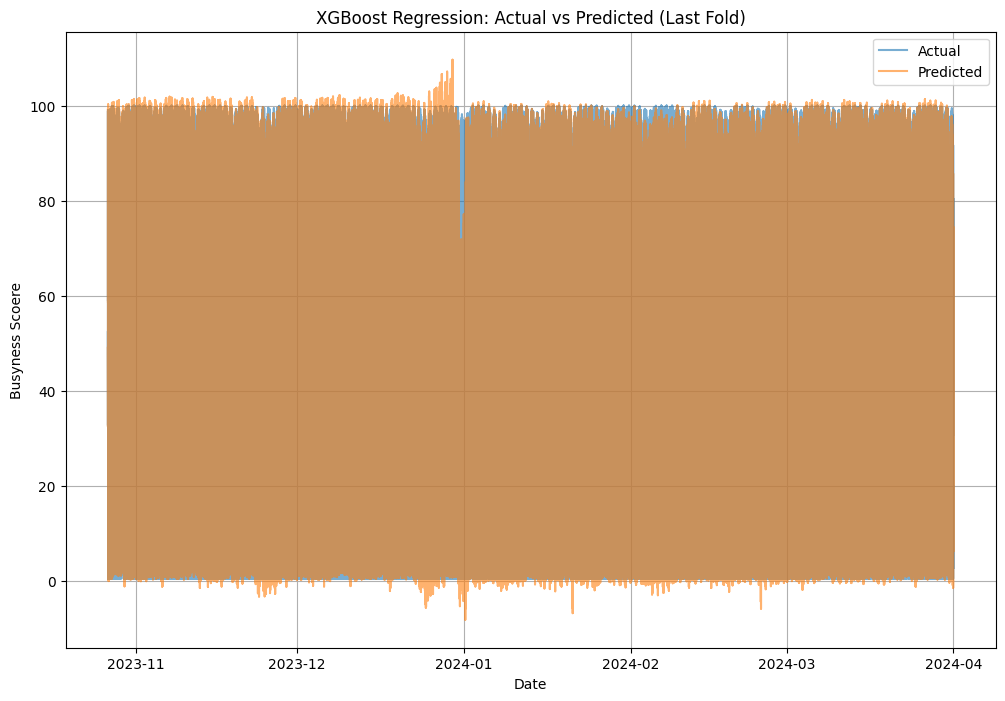

Average Mean Squared Error (MSE): 16.53
Average Root Mean Squared Error (RMSE): 4.00
Average R-squared (R2): 0.98
Average Mean Absolute Error (MAE): 2.57


In [35]:
features = [
        'hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'weekday_sin', 'weekday_cos', 'month_sin', 'month_cos', 
        'week_sin', 'week_cos', 'year_sin', 'year_cos', 'is_weekend', 'is_rush_hour', 'subway_station_present', 
        'is_holiday'
    ]

rolling_features = ['rolling_mean_24h', 'rolling_std_24h', 'rolling_mean_7d', 'rolling_std_7d']
lagged_features = ['lag_1h', 'lag_24h', 'lag_7d']

X = busyness_df[features + rolling_features + lagged_features + ['zone_id']]
y = busyness_df['ridership_percentile']

# One-hot encode the 'zone_id' feature
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), features),
        ('cat', OneHotEncoder(), ['zone_id'])
    ])

# Create a pipeline that scales features and trains the model
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', xgb.XGBRegressor(
        objective='reg:squarederror',
        n_estimators=362,
        learning_rate=0.12912411467580226,
        max_depth=10,
        subsample=0.9620454248709411,
        colsample_bytree=0.8287274232003768,
        min_child_weight=5,
        reg_alpha=0.23532591326140717,
        reg_lambda=0.4725786342513321,
        random_state=42))
])

# Initialize KFold cross-validation
kf = KFold(n_splits=5, shuffle=False)

# Arrays to store performance metrics for each fold
mse_list = []
rmse_list = []
r2_list = []
mae_list = []

# Loop through each fold
for train_index, test_index in kf.split(X):
    # Split the data into training and testing sets for this fold
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Fit the pipeline
    pipeline.fit(X_train, y_train)

    # Predictions
    y_pred = pipeline.predict(X_test)

    # Calculate performance metrics
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)

    mse_list.append(mse)
    rmse_list.append(rmse)
    r2_list.append(r2)
    mae_list.append(mae)

    # Plotting predictions vs actual for the last fold
    if len(mse_list) == kf.get_n_splits():
        plt.figure(figsize=(12, 8))
        plt.plot(busyness_df['transit_timestamp'].iloc[test_index], y_test, label='Actual', alpha=0.6)
        plt.plot(busyness_df['transit_timestamp'].iloc[test_index], y_pred, label='Predicted', alpha=0.6)
        plt.xlabel('Date')
        plt.ylabel('Busyness Scoere')
        plt.title('XGBoost Regression: Actual vs Predicted (Last Fold)')
        plt.legend()
        plt.grid(True)
        plt.show()

# Print average metrics across all folds
print(f'Average Mean Squared Error (MSE): {np.mean(mse_list):.2f}')
print(f'Average Root Mean Squared Error (RMSE): {np.mean(rmse_list):.2f}')
print(f'Average R-squared (R2): {np.mean(r2_list):.2f}')
print(f'Average Mean Absolute Error (MAE): {np.mean(mae_list):.2f}')


In [36]:
mean_target_variable = busyness_df['ridership_percentile'].mean()
std_target_variable = busyness_df['ridership_percentile'].std()
median_target_variable = busyness_df['ridership_percentile'].median()

# RMSE value
rmse = np.mean(rmse_list)

# Relative RMSE
relative_rmse_mean = (rmse / mean_target_variable) * 100
relative_rmse_median = (rmse / median_target_variable) * 100


print(f"Relative RMSE (as a percentage of mean): {relative_rmse_mean:.2f}%")
print(f"Relative RMSE (as a percentage of median): {relative_rmse_median:.2f}%")

Relative RMSE (as a percentage of mean): 7.99%
Relative RMSE (as a percentage of median): 7.98%


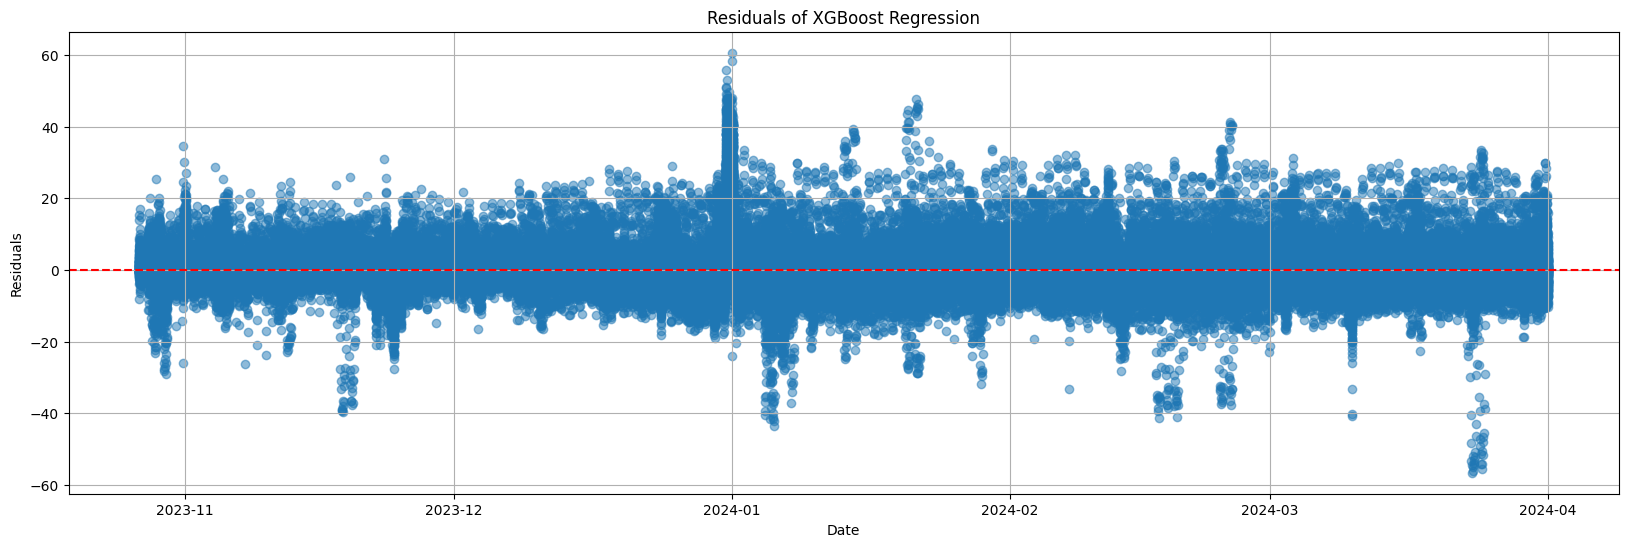

In [37]:
# Calculate residuals
residuals = y_test - y_pred

# Plot residuals
plt.figure(figsize=(20, 6))

plt.scatter(busyness_df['transit_timestamp'].iloc[test_index], residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.title('Residuals of XGBoost Regression')
plt.grid(True)
plt.show()

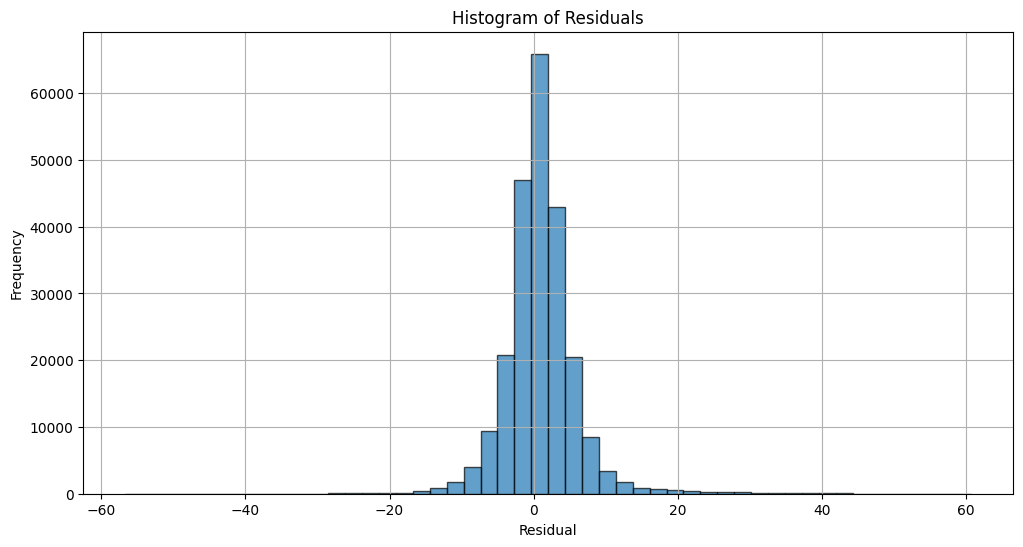

In [38]:
# Plot the histogram of the residuals
plt.figure(figsize=(12, 6))
plt.hist(residuals, bins=50, edgecolor='k', alpha=0.7)
plt.title('Histogram of Residuals')
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [41]:
historical_rolling_features_df = busyness_df.copy()
historical_rolling_features_df = historical_rolling_features_df[['transit_timestamp','zone_id','rolling_mean_24h', 'rolling_std_24h', 'rolling_mean_7d', 'rolling_std_7d','lag_1h', 'lag_24h', 'lag_7d']]
historical_rolling_features_df.head()

,transit_timestamp,zone_id,rolling_mean_24h,rolling_std_24h,rolling_mean_7d,rolling_std_7d,lag_1h,lag_24h,lag_7d
0,2022-02-08,230,78.541734,24.193190,78.858643,21.652685,74.780839,55.638781,62.969509
1,2022-02-08,148,53.239718,24.099840,54.172313,20.581838,39.852045,31.183386,31.468605
2,2022-02-08,42,44.198122,22.229631,41.555205,19.834488,21.189606,16.868878,16.703865
3,2022-02-08,43,46.564778,27.281978,41.555205,19.834488,32.925711,17.183398,16.703865
4,2022-02-08,45,37.739840,24.361370,41.555205,19.834488,22.923835,17.029437,16.703865


In [42]:
zones_df = pd.read_csv('../datasets/zones_df.csv')

In [43]:
#pickle the model and include the zones_df and df into it
data = {
    'pipeline': pipeline,
    'zones_df': zones_df,
    'historical_rolling_features_df': historical_rolling_features_df
}

with open('busyness_model_percentiles.pkl', 'wb') as f:
    pickle.dump(data, f)

log_ridership has moderate to strong positive correlations with log_lag_1h, log_lag_24h, and log_lag_7d, indicating past ridership values are good predictors of current ridership.

Dimensionality reduction techniques (e.g., PCA) considered - multicollinearity might be an issue due to highly correlated features.

In [39]:
busyness_df

,transit_timestamp,zone_id,subway_station_present,total_ridership,ridership_percentile,log_ridership_percentile,log_ridership,is_holiday,hour,day,...,lag_1h,lag_24h,lag_7d,log_rolling_mean_24h,log_rolling_std_24h,log_rolling_mean_7d,log_rolling_std_7d,log_lag_1h,log_lag_24h,log_lag_7d
0,2022-02-08,230,True,928,62.733512,4.154711,6.834109,False,0,8,...,74.780839,55.638781,62.969509,4.376282,3.226574,4.380258,3.120278,4.327845,4.036694,4.158407
1,2022-02-08,148,True,162,27.974873,3.366429,5.093750,False,0,8,...,39.852045,31.183386,31.468605,3.993413,3.222861,4.010461,3.071852,3.709957,3.471450,3.480274
2,2022-02-08,42,True,70,16.379749,2.855306,4.262680,False,0,8,...,21.189606,16.868878,16.703865,3.811056,3.145429,3.750802,3.036610,3.099624,2.883061,2.873783
3,2022-02-08,43,True,96,20.274877,3.057527,4.574711,False,0,8,...,32.925711,17.183398,16.703865,3.862093,3.342225,3.750802,3.036610,3.524173,2.900509,2.873783
4,2022-02-08,45,True,61,14.881732,2.765169,4.127134,False,0,8,...,22.923835,17.029437,16.703865,3.656869,3.233227,3.750802,3.036610,3.174875,2.892006,2.873783
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1156825,2024-04-01,249,True,242,35.328434,3.592601,5.493061,False,0,1,...,47.895733,67.607199,34.864065,3.860927,2.944348,3.861163,3.012469,3.889690,4.228397,3.579736
1156826,2024-04-01,152,True,29,8.598403,2.261597,3.401197,False,0,1,...,12.893385,22.320713,38.309818,3.343445,2.663224,3.581671,2.912549,2.631413,3.149342,3.671474
1156827,2024-04-01,230,True,1940,80.413023,4.399535,7.570959,False,0,1,...,91.643934,93.724682,77.942401,4.476322,2.938892,4.493844,3.003847,4.528763,4.550975,4.368718
1156828,2024-04-01,261,True,144,26.030950,3.296983,4.976734,False,0,1,...,37.316737,45.357770,82.539523,4.028615,3.260329,4.196564,3.328849,3.645887,3.836389,4.425320


In [ ]:
""" 
Principal Component Analysis
Standardize the Data
"""
features = [
    'hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'weekday_sin', 'weekday_cos', 'month_sin', 'month_cos', 'week_sin', 'week_cos', 'year_sin', 'year_cos',
    'is_weekend', 'is_rush_hour', 'subway_station_present', 'is_holiday'
]
X = busyness_df[features]
y = busyness_df['ridership_percentile']

# Standardizing the features
scaler = StandardScaler()
x = scaler.fit_transform(X)

In [ ]:
len(features)

16

In [ ]:
""" 
Apply PCA
"""
# Performing PCA
pca = PCA()
principal_components = pca.fit_transform(x)

# Creating a DataFrame with the principal components
pca_df = pd.DataFrame(data = principal_components)

In [ ]:
pca_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,1.698888,-0.730632,0.052363,-1.056629,-0.330415,1.450827,1.477388,1.219855,0.724978,1.982958,-1.040070,-0.056369,-0.931029,-0.099977,-0.168200,0.112879
1,1.707410,-0.721710,0.059366,-1.042340,-0.521151,1.763491,0.695097,1.184950,-0.515241,-0.221084,-1.052622,-0.023239,-0.935493,-0.101318,-0.168049,0.113045
2,1.707410,-0.721710,0.059366,-1.042340,-0.521151,1.763491,0.695097,1.184950,-0.515241,-0.221084,-1.052622,-0.023239,-0.935493,-0.101318,-0.168049,0.113045
3,1.707410,-0.721710,0.059366,-1.042340,-0.521151,1.763491,0.695097,1.184950,-0.515241,-0.221084,-1.052622,-0.023239,-0.935493,-0.101318,-0.168049,0.113045
4,1.707410,-0.721710,0.059366,-1.042340,-0.521151,1.763491,0.695097,1.184950,-0.515241,-0.221084,-1.052622,-0.023239,-0.935493,-0.101318,-0.168049,0.113045
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1167171,1.402608,0.103403,-1.687426,-0.465782,0.150183,1.503199,1.479654,1.233745,0.747715,1.925439,-1.061739,-0.346376,1.699753,0.710599,-0.173858,-0.086825
1167172,1.411130,0.112325,-1.680423,-0.451492,-0.040553,1.815863,0.697363,1.198840,-0.492503,-0.278603,-1.074291,-0.313245,1.695289,0.709258,-0.173707,-0.086658
1167173,1.411130,0.112325,-1.680423,-0.451492,-0.040553,1.815863,0.697363,1.198840,-0.492503,-0.278603,-1.074291,-0.313245,1.695289,0.709258,-0.173707,-0.086658
1167174,1.411130,0.112325,-1.680423,-0.451492,-0.040553,1.815863,0.697363,1.198840,-0.492503,-0.278603,-1.074291,-0.313245,1.695289,0.709258,-0.173707,-0.086658


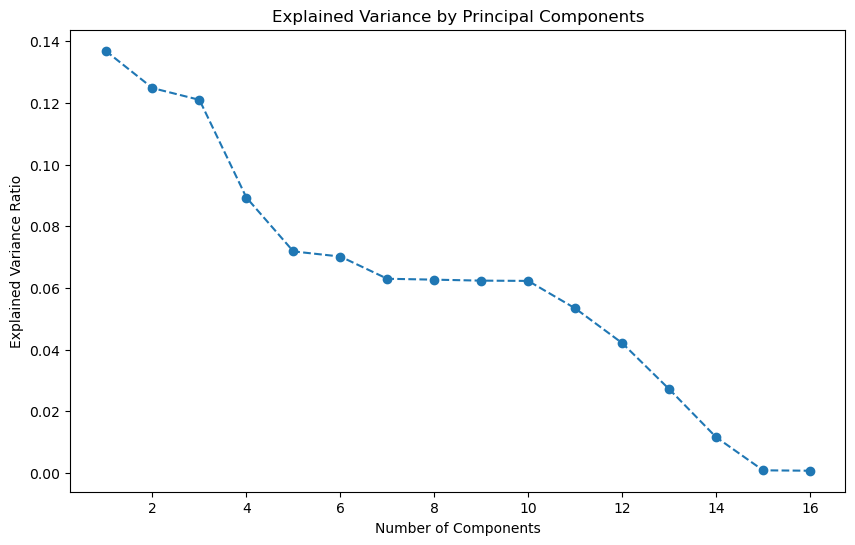

In [ ]:
""" 
Determine the Number of Components
"""

# Explained variance ratio
explained_variance = pca.explained_variance_ratio_

# Plotting the explained variance to determine the number of components to retain
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='--')
plt.title('Explained Variance by Principal Components')
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance Ratio')
plt.show()


In [ ]:
""" 
Transform the Data
Based on the plot, decide how many components to keep (the components that explain most of the variance).
"""
# Selecting the number of components
n_components = 15 

# Applying PCA with the selected number of components
pca = PCA(n_components=n_components)
principal_components = pca.fit_transform(x)

# Creating a DataFrame with the principal components
pca_df = pd.DataFrame(data = principal_components, columns = [f'PC{i+1}' for i in range(n_components)])

# Concatenating with the target variable
final_df = pd.concat([pca_df, busyness_df[['ridership_percentile']]], axis=1)

In [ ]:
final_df

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,ridership_percentile
0,1.698888,-0.730632,0.052363,-1.056629,-0.330415,1.450827,1.477388,1.219855,0.724978,1.982958,-1.040070,-0.056369,-0.931029,-0.099977,-0.168200,0.064317
1,1.707410,-0.721710,0.059366,-1.042340,-0.521151,1.763491,0.695097,1.184950,-0.515241,-0.221084,-1.052622,-0.023239,-0.935493,-0.101318,-0.168049,0.290182
2,1.707410,-0.721710,0.059366,-1.042340,-0.521151,1.763491,0.695097,1.184950,-0.515241,-0.221084,-1.052622,-0.023239,-0.935493,-0.101318,-0.168049,0.553101
3,1.707410,-0.721710,0.059366,-1.042340,-0.521151,1.763491,0.695097,1.184950,-0.515241,-0.221084,-1.052622,-0.023239,-0.935493,-0.101318,-0.168049,0.488711
4,1.707410,-0.721710,0.059366,-1.042340,-0.521151,1.763491,0.695097,1.184950,-0.515241,-0.221084,-1.052622,-0.023239,-0.935493,-0.101318,-0.168049,0.378303
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1167171,1.402608,0.103403,-1.687426,-0.465782,0.150183,1.503199,1.479654,1.233745,0.747715,1.925439,-1.061739,-0.346376,1.699753,0.710599,-0.173858,0.099012
1167172,1.411130,0.112325,-1.680423,-0.451492,-0.040553,1.815863,0.697363,1.198840,-0.492503,-0.278603,-1.074291,-0.313245,1.695289,0.709258,-0.173707,0.260309
1167173,1.411130,0.112325,-1.680423,-0.451492,-0.040553,1.815863,0.697363,1.198840,-0.492503,-0.278603,-1.074291,-0.313245,1.695289,0.709258,-0.173707,0.429712
1167174,1.411130,0.112325,-1.680423,-0.451492,-0.040553,1.815863,0.697363,1.198840,-0.492503,-0.278603,-1.074291,-0.313245,1.695289,0.709258,-0.173707,0.317453


In [ ]:
# Split the data into initial training and testing sets
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize KFold cross-validation
kf = KFold(n_splits=5, shuffle=False)

# Arrays to store performance metrics for each fold
mse_list = []
rmse_list = []
r2_list = []
mae_list = []

# Loop through each fold within the training set
for train_index, val_index in kf.split(X_train_full):
    # Split the data into training and validation sets for this fold
    X_train, X_val = X_train_full.iloc[train_index], X_train_full.iloc[val_index]
    y_train, y_val = y_train_full.iloc[train_index], y_train_full.iloc[val_index]

    # Defining the pipeline
    pipeline = Pipeline(steps=[
        ('scaler', StandardScaler()),
        ('pca', PCA(n_components=15)),
        ('model', XGBRegressor(
            objective='reg:squarederror',
            n_estimators=362,
            learning_rate=0.12912411467580226,
            max_depth=10,
            subsample=0.9620454248709411,
            colsample_bytree=0.8287274232003768,
            min_child_weight=5,
            reg_alpha=0.23532591326140717,
            reg_lambda=0.4725786342513321,
            random_state=42))
    ])

    # Fit the pipeline
    pipeline.fit(X_train, y_train)

    # Predictions
    y_pred = pipeline.predict(X_val)

    # Calculate performance metrics
    mse = mean_squared_error(y_val, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_val, y_pred)
    mae = mean_absolute_error(y_val, y_pred)

    mse_list.append(mse)
    rmse_list.append(rmse)
    r2_list.append(r2)
    mae_list.append(mae)

# Print the average metrics across all folds
print(f'Average MSE: {np.mean(mse_list)}')
print(f'Average RMSE: {np.mean(rmse_list)}')
print(f'Average R2: {np.mean(r2_list)}')
print(f'Average MAE: {np.mean(mae_list)}')

# Evaluate on the hold-out test set
pipeline.fit(X_train_full, y_train_full)
y_test_pred = pipeline.predict(X_test)

# Calculate performance metrics on the test set
test_mse = mean_squared_error(y_test, y_test_pred)
test_rmse = np.sqrt(test_mse)
test_r2 = r2_score(y_test, y_test_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)

print(f'Test MSE: {test_mse}')
print(f'Test RMSE: {test_rmse}')
print(f'Test R2: {test_r2}')
print(f'Test MAE: {test_mae}')

Average MSE: 0.02738919375147752
Average RMSE: 0.16549674640071257
Average R2: 0.671153077181718
Average MAE: 0.13309992473033647
Test MSE: 0.027176953545847687
Test RMSE: 0.16485434039129115
Test R2: 0.6745609613724228
Test MAE: 0.13266199827550898


In [ ]:
# component_range = range(20, 25)  # Example range for number of components
# results = []

# for n_components in component_range:
#     kf = KFold(n_splits=5, shuffle=False)
#     mse_list = []
#     rmse_list = []
#     r2_list = []
#     mae_list = []

#     for train_index, test_index in kf.split(X):
#         X_train, X_test = X.iloc[train_index], X.iloc[test_index]
#         y_train, y_test = y.iloc[train_index], y.iloc[test_index]

#         pipeline = Pipeline(steps=[
#             ('scaler', StandardScaler()),
#             ('pca', PCA(n_components=n_components)),
#             ('model', XGBRegressor(
#                 objective='reg:squarederror',
#                 n_estimators=362,
#                 learning_rate=0.12912411467580226,
#                 max_depth=10,
#                 subsample=0.9620454248709411,
#                 colsample_bytree=0.8287274232003768,
#                 min_child_weight=5,
#                 reg_alpha=0.23532591326140717,
#                 reg_lambda=0.4725786342513321,
#                 random_state=42))
#         ])

#         pipeline.fit(X_train, y_train)
#         y_pred = pipeline.predict(X_test)

#         mse = mean_squared_error(y_test, y_pred)
#         rmse = np.sqrt(mse)
#         r2 = r2_score(y_test, y_pred)
#         mae = mean_absolute_error(y_test, y_pred)

#         mse_list.append(mse)
#         rmse_list.append(rmse)
#         r2_list.append(r2)
#         mae_list.append(mae)

#     results.append({
#         'n_components': n_components,
#         'avg_mse': np.mean(mse_list),
#         'avg_rmse': np.mean(rmse_list),
#         'avg_r2': np.mean(r2_list),
#         'avg_mae': np.mean(mae_list)
#     })

# # Print results for each number of components
# for result in results:
#     print(f"Components: {result['n_components']}, MSE: {result['avg_mse']}, RMSE: {result['avg_rmse']}, R2: {result['avg_r2']}, MAE: {result['avg_mae']}")

After testing, 20 components seems good (changed code above) for log_ridership:

Components: 5, MSE: 0.25391714756968736, RMSE: 0.5033231844727954, R2: 0.9204310923450967, MAE: 0.3523886056762567
Components: 6, MSE: 0.26644408256235835, RMSE: 0.5158166542317526, R2: 0.9164014376471548, MAE: 0.3667133214524489
Components: 7, MSE: 0.2849333944199125, RMSE: 0.529921170120825, R2: 0.9109033275385638, MAE: 0.3831384574430848
Components: 8, MSE: 0.4162306084345947, RMSE: 0.614443911776008, R2: 0.867666384517977, MAE: 0.45288286074354056
Components: 9, MSE: 0.19062033495605135, RMSE: 0.4346184692781966, R2: 0.9399189532682666, MAE: 0.3039587339781229
Components: 10, MSE: 0.12406403962049184, RMSE: 0.3521405521341018, R2: 0.9610259582249288, MAE: 0.2383703591780945
Components: 11, MSE: 0.1244006281179459, RMSE: 0.3526383890131154, R2: 0.9609015060255486, MAE: 0.23978147800256006
Components: 12, MSE: 0.09464576483998602, RMSE: 0.30759634409594466, R2: 0.970283267851314, MAE: 0.20201749634655952
Components: 13, MSE: 0.10832590677692602, RMSE: 0.32567339688223323, R2: 0.9659713005484765, MAE: 0.22161310043436594
Components: 14, MSE: 0.12842051636947602, RMSE: 0.35332884104833945, R2: 0.9592557444183176, MAE: 0.24462110170421977
Components: 15, MSE: 0.09459519796794602, RMSE: 0.3060716534541298, R2: 0.9701880268878492, MAE: 0.2017823144937755
Components: 16, MSE: 0.07363042408059593, RMSE: 0.27060134114993367, R2: 0.9768775562974221, MAE: 0.17216696202134454
Components: 17, MSE: 0.0778736628087667, RMSE: 0.27862609428977125, R2: 0.9755726878832736, MAE: 0.1799850302721158
Components: 18, MSE: 0.0701063367699394, RMSE: 0.2643092998610239, R2: 0.9779960808423425, MAE: 0.1658579470405818
Components: 19, MSE: 0.06915603073661615, RMSE: 0.26252171757695536, R2: 0.9782830357502356, MAE: 0.16742809415501564
Components: 20, MSE: 0.06229720872982558, RMSE: 0.2492300937150894, R2: 0.9804391326834114, MAE: 0.15685796223005183
Components: 21, MSE: 0.06297067585030486, RMSE: 0.2504021753278207, R2: 0.9802332239516833, MAE: 0.15897239008392108
Components: 22, MSE: 0.06074939933177653, RMSE: 0.2459137475917204, R2: 0.9809317186626736, MAE: 0.1567886445853664
Components: 23, MSE: 0.05961507320136813, RMSE: 0.2434898541520331, R2: 0.9812818607699949, MAE: 0.15416442848864292
Components: 24, MSE: 0.058023924764775234, RMSE: 0.24033024401579145, R2: 0.9817782754739396, MAE: 0.15310629442210572

In [ ]:
#export the model to a pickle file
with open('xgboost_busyness_model.pkl', 'wb') as f:
    pickle.dump(pipeline, f)

In [ ]:
#export combined busyness_df to csv wthout index
future_busyness_df.to_csv('future_busyness_df.csv', index=False)

In [ ]:
zones_busyness_df = busyness_df[['zone_id', 'subway_station_present','zone_area_km2']].drop_duplicates()
zones_busyness_df.to_csv('zones_busyness_df.csv', index=False)

In [ ]:
latest_data = busyness_df[busyness_df['transit_timestamp'] >= (start_date - pd.Timedelta(days=60))].reset_index(drop=True)
latest_data.to_csv('latest_historical_data.csv', index=False)

In [ ]:
prediction_time = '2024-04-02 22:00:00'


# Load the model from a pickle file
with open('xgboost_busyness_model.pkl', 'rb') as f:
    pipeline = pickle.load(f)


# Define the date for prediction
start_date = pd.Timestamp('2024-04-01 00:00:00') #last time recorded in the dataset.
end_date = pd.Timestamp(prediction_time) #the time when we are interested to make a prediction.

#this is the rane of timestamps for which the model will be run.
date_range = pd.date_range(start=start_date + pd.Timedelta(hours=1), end=end_date, freq='H')


# zones_busyness_df = busyness_df[['zone_id', 'subway_station_present','zone_area_km2']].drop_duplicates()

zones_busyness_df = pd.read_csv('./zones_busyness_df.csv')

#return the zone_ids from zones_busyness_df and save them in a list
zones = zones_busyness_df['zone_id'].tolist()

#construct the time and zone columns and add them to the future_busyness_df
future_busyness_df = pd.DataFrame([(zone, date) for zone in zones for date in date_range], columns=['zone_id', 'transit_timestamp'])

# Merge the zones_busyness_df to include subway_station_present in future_busyness_df
future_busyness_df = future_busyness_df.merge(zones_busyness_df, on='zone_id', how='left')

# Create time-based features for the future dates
future_busyness_df['hour'] = future_busyness_df['transit_timestamp'].dt.hour
future_busyness_df['day'] = future_busyness_df['transit_timestamp'].dt.day
future_busyness_df['weekday'] = future_busyness_df['transit_timestamp'].dt.weekday
future_busyness_df['month'] = future_busyness_df['transit_timestamp'].dt.month
future_busyness_df['year'] = future_busyness_df['transit_timestamp'].dt.year
future_busyness_df['week'] = future_busyness_df['transit_timestamp'].dt.isocalendar().week
future_busyness_df['is_weekend'] = future_busyness_df['weekday'] >= 5
future_busyness_df['is_rush_hour'] = future_busyness_df['hour'].isin([7, 8, 9, 16, 17, 18, 19]) & ~future_busyness_df['is_weekend']

# Create cyclic features for hour, month, week, and year
min_year = 2022
max_year = max(2024,end_date.year)

future_busyness_df['hour_sin'] = np.sin(2 * np.pi * future_busyness_df['hour'] / 24)
future_busyness_df['hour_cos'] = np.cos(2 * np.pi * future_busyness_df['hour'] / 24)
future_busyness_df['day_sin'] = np.sin(2 * np.pi * future_busyness_df['day'] / 31)
future_busyness_df['day_cos'] = np.cos(2 * np.pi * future_busyness_df['day'] / 31)
future_busyness_df['weekday_sin'] = np.sin(2 * np.pi * future_busyness_df['weekday'] / 7)
future_busyness_df['weekday_cos'] = np.cos(2 * np.pi * future_busyness_df['weekday'] / 7)
future_busyness_df['month_sin'] = np.sin(2 * np.pi * future_busyness_df['month'] / 12)
future_busyness_df['month_cos'] = np.cos(2 * np.pi * future_busyness_df['month'] / 12)
future_busyness_df['week_sin'] = np.sin(2 * np.pi * future_busyness_df['week'] / 52)
future_busyness_df['week_cos'] = np.cos(2 * np.pi * future_busyness_df['week'] / 52)
future_busyness_df['year_sin'] = np.sin(2 * np.pi * (future_busyness_df['year'] - min_year) / (max_year - min_year + 1))
future_busyness_df['year_cos'] = np.cos(2 * np.pi * (future_busyness_df['year'] - min_year) / (max_year - min_year + 1))


# Initialize columns for rolling and lagged features
rolling_features = ['rolling_mean_24h', 'rolling_std_24h', 'rolling_mean_7d', 'rolling_std_7d']
lagged_features = ['lag_1h', 'lag_24h', 'lag_7d']
log_features = ['log_' + feat for feat in rolling_features + lagged_features]

# fill the values with NaN initially.
for feat in rolling_features + lagged_features + log_features:
    future_busyness_df[feat] = np.nan

# Copy the latest available rolling and lagged feature values to the future DataFrame
# latest_data = busyness_df[busyness_df['transit_timestamp'] >= (start_date - pd.Timedelta(days=60))].reset_index(drop=True)
latest_data = pd.read_csv('./latest_historical_data.csv')
latest_data['transit_timestamp'] = pd.to_datetime(latest_data['transit_timestamp'])
# Prepend latest_data to future_busyness_df
combined_busyness_df = pd.concat([latest_data, future_busyness_df], ignore_index=True)

# Sort by 'transit_timestamp' to ensure correct order
combined_busyness_df = combined_busyness_df.sort_values(by='transit_timestamp').reset_index(drop=True)

features = [
    'hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'weekday_sin', 'weekday_cos', 'month_sin', 'month_cos', 'week_sin', 'week_cos', 'year_sin', 'year_cos',
    'is_weekend', 'is_rush_hour', 'zone_area_km2', 'subway_station_present',
    'log_rolling_mean_24h', 'log_rolling_std_24h', 'log_rolling_mean_7d', 'log_rolling_std_7d',
    'log_lag_1h', 'log_lag_24h', 'log_lag_7d'
]

future_busyness_df = combined_busyness_df.copy()


future_busyness_df.drop(['total_ridership', 'subway_ridership', 'taxi_ridership','log_taxi_ridership','log_subway_ridership','log_zone_area_km2','busyness_score'], axis=1, inplace=True)


# Iterate through the date range and fill missing data
for date in date_range:
    for zone in zones:
        # zone_busyness_df = future_busyness_df[future_busyness_df['zone_id'] == zone]
        # current_idx = (future_busyness_df['zone_id'] == zone) & (future_busyness_df['transit_timestamp'] <= date)
        zone_busyness_df = future_busyness_df[(future_busyness_df['zone_id'] == zone) & (future_busyness_df['transit_timestamp'] <= date)]
        current_idx = (future_busyness_df['zone_id'] == zone) & (future_busyness_df['transit_timestamp'] == date)
        # Update rolling and lagged features
        future_busyness_df.loc[current_idx, 'rolling_mean_24h'] = zone_busyness_df['log_busyness_score'].shift(1).rolling(window=24).mean().iloc[-1]
        future_busyness_df.loc[current_idx, 'rolling_std_24h'] = zone_busyness_df['log_busyness_score'].shift(1).rolling(window=24).std().iloc[-1]
        future_busyness_df.loc[current_idx, 'rolling_mean_7d'] = zone_busyness_df['log_busyness_score'].shift(1).rolling(window=24*7).mean().iloc[-1]
        future_busyness_df.loc[current_idx, 'rolling_std_7d'] = zone_busyness_df['log_busyness_score'].shift(1).rolling(window=24*7).std().iloc[-1]
        future_busyness_df.loc[current_idx, 'lag_1h'] = zone_busyness_df['log_busyness_score'].shift(1).iloc[-1]
        future_busyness_df.loc[current_idx, 'lag_24h'] = zone_busyness_df['log_busyness_score'].shift(24).iloc[-1]
        future_busyness_df.loc[current_idx, 'lag_7d'] = zone_busyness_df['log_busyness_score'].shift(24*7).iloc[-1]

        # Apply log transformation
        future_busyness_df.loc[current_idx, 'log_rolling_mean_24h'] = np.log1p(future_busyness_df.loc[current_idx, 'rolling_mean_24h'])
        future_busyness_df.loc[current_idx, 'log_rolling_std_24h'] = np.log1p(future_busyness_df.loc[current_idx, 'rolling_std_24h'])
        future_busyness_df.loc[current_idx, 'log_rolling_mean_7d'] = np.log1p(future_busyness_df.loc[current_idx, 'rolling_mean_7d'])
        future_busyness_df.loc[current_idx, 'log_rolling_std_7d'] = np.log1p(future_busyness_df.loc[current_idx, 'rolling_std_7d'])
        future_busyness_df.loc[current_idx, 'log_lag_1h'] = np.log1p(future_busyness_df.loc[current_idx, 'lag_1h'])
        future_busyness_df.loc[current_idx, 'log_lag_24h'] = np.log1p(future_busyness_df.loc[current_idx, 'lag_24h'])
        future_busyness_df.loc[current_idx, 'log_lag_7d'] = np.log1p(future_busyness_df.loc[current_idx, 'lag_7d'])

        # Prepare features for the current date
        X_current = future_busyness_df.loc[current_idx, features + ['zone_id']]
        X_current_transformed = pipeline.named_steps['preprocessor'].transform(X_current)
        y_current_pred = pipeline.named_steps['model'].predict(X_current_transformed)
        future_busyness_df.loc[current_idx, 'log_busyness_score'] = y_current_pred


In [ ]:
def make_predictions(prediction_time,path_to_pickle_file, path_to_zones_csv, path_to_latest_historical_data_csv):

    '''
    this functions returns a pandas dataframe with the predictions for the specified time for all taxi zones.
    make sure to import pickle, pandas as pd and numpy as np

    '''

    # prediction_time = '2024-04-02 08:00:00'


    # Load the model from a pickle file
    with open(path_to_pickle_file, 'rb') as f:
        pipeline = pickle.load(f)


    # Define the date for prediction
    start_date = pd.Timestamp('2024-04-01 00:00:00') #last time recorded in the dataset.
    end_date = pd.Timestamp(prediction_time) #the time when we are interested to make a prediction.

    #this is the rane of timestamps for which the model will be run.
    date_range = pd.date_range(start=start_date + pd.Timedelta(hours=1), end=end_date, freq='H')


    # zones_busyness_df = busyness_df[['zone_id', 'subway_station_present','zone_area_km2']].drop_duplicates()

    zones_busyness_df = pd.read_csv(path_to_zones_csv)

    #return the zone_ids from zones_busyness_df and save them in a list
    zones = zones_busyness_df['zone_id'].tolist()

    #construct the time and zone columns and add them to the future_busyness_df
    future_busyness_df = pd.DataFrame([(zone, date) for zone in zones for date in date_range], columns=['zone_id', 'transit_timestamp'])

    # Merge the zones_busyness_df to include subway_station_present in future_busyness_df
    future_busyness_df = future_busyness_df.merge(zones_busyness_df, on='zone_id', how='left')

    # Create time-based features for the future dates
    future_busyness_df['hour'] = future_busyness_df['transit_timestamp'].dt.hour
    future_busyness_df['day'] = future_busyness_df['transit_timestamp'].dt.day
    future_busyness_df['weekday'] = future_busyness_df['transit_timestamp'].dt.weekday
    future_busyness_df['month'] = future_busyness_df['transit_timestamp'].dt.month
    future_busyness_df['year'] = future_busyness_df['transit_timestamp'].dt.year
    future_busyness_df['week'] = future_busyness_df['transit_timestamp'].dt.isocalendar().week
    future_busyness_df['is_weekend'] = future_busyness_df['weekday'] >= 5
    future_busyness_df['is_rush_hour'] = future_busyness_df['hour'].isin([7, 8, 9, 16, 17, 18, 19]) & ~future_busyness_df['is_weekend']

    # Create cyclic features for hour, month, week, and year
    min_year = 2022
    max_year = max(2024,end_date.year)

    future_busyness_df['hour_sin'] = np.sin(2 * np.pi * future_busyness_df['hour'] / 24)
    future_busyness_df['hour_cos'] = np.cos(2 * np.pi * future_busyness_df['hour'] / 24)
    future_busyness_df['day_sin'] = np.sin(2 * np.pi * future_busyness_df['day'] / 31)
    future_busyness_df['day_cos'] = np.cos(2 * np.pi * future_busyness_df['day'] / 31)
    future_busyness_df['weekday_sin'] = np.sin(2 * np.pi * future_busyness_df['weekday'] / 7)
    future_busyness_df['weekday_cos'] = np.cos(2 * np.pi * future_busyness_df['weekday'] / 7)
    future_busyness_df['month_sin'] = np.sin(2 * np.pi * future_busyness_df['month'] / 12)
    future_busyness_df['month_cos'] = np.cos(2 * np.pi * future_busyness_df['month'] / 12)
    future_busyness_df['week_sin'] = np.sin(2 * np.pi * future_busyness_df['week'] / 52)
    future_busyness_df['week_cos'] = np.cos(2 * np.pi * future_busyness_df['week'] / 52)
    future_busyness_df['year_sin'] = np.sin(2 * np.pi * (future_busyness_df['year'] - min_year) / (max_year - min_year + 1))
    future_busyness_df['year_cos'] = np.cos(2 * np.pi * (future_busyness_df['year'] - min_year) / (max_year - min_year + 1))


    # Initialize columns for rolling and lagged features
    rolling_features = ['rolling_mean_24h', 'rolling_std_24h', 'rolling_mean_7d', 'rolling_std_7d']
    lagged_features = ['lag_1h', 'lag_24h', 'lag_7d']
    log_features = ['log_' + feat for feat in rolling_features + lagged_features]

    # fill the values with NaN initially.
    for feat in rolling_features + lagged_features + log_features:
        future_busyness_df[feat] = np.nan

    # Copy the latest available rolling and lagged feature values to the future DataFrame
    # latest_data = busyness_df[busyness_df['transit_timestamp'] >= (start_date - pd.Timedelta(days=60))].reset_index(drop=True)
    latest_data = pd.read_csv(path_to_latest_historical_data_csv)
    latest_data['transit_timestamp'] = pd.to_datetime(latest_data['transit_timestamp'])
    # Prepend latest_data to future_busyness_df
    combined_busyness_df = pd.concat([latest_data, future_busyness_df], ignore_index=True)

    # Sort by 'transit_timestamp' to ensure correct order
    combined_busyness_df = combined_busyness_df.sort_values(by='transit_timestamp').reset_index(drop=True)

    features = [
        'hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'weekday_sin', 'weekday_cos', 'month_sin', 'month_cos', 'week_sin', 'week_cos', 'year_sin', 'year_cos',
        'is_weekend', 'is_rush_hour', 'zone_area_km2', 'subway_station_present',
        'log_rolling_mean_24h', 'log_rolling_std_24h', 'log_rolling_mean_7d', 'log_rolling_std_7d',
        'log_lag_1h', 'log_lag_24h', 'log_lag_7d'
    ]

    future_busyness_df = combined_busyness_df.copy()


    future_busyness_df.drop(['total_ridership', 'subway_ridership', 'taxi_ridership','log_taxi_ridership','log_subway_ridership','log_zone_area_km2','busyness_score'], axis=1, inplace=True)


    # Iterate through the date range and fill missing data
    for date in date_range:
        for zone in zones:
            # zone_busyness_df = future_busyness_df[future_busyness_df['zone_id'] == zone]
            # current_idx = (future_busyness_df['zone_id'] == zone) & (future_busyness_df['transit_timestamp'] <= date)
            zone_busyness_df = future_busyness_df[(future_busyness_df['zone_id'] == zone) & (future_busyness_df['transit_timestamp'] <= date)]
            current_idx = (future_busyness_df['zone_id'] == zone) & (future_busyness_df['transit_timestamp'] == date)
            # Update rolling and lagged features
            future_busyness_df.loc[current_idx, 'rolling_mean_24h'] = zone_busyness_df['log_busyness_score'].shift(1).rolling(window=24).mean().iloc[-1]
            future_busyness_df.loc[current_idx, 'rolling_std_24h'] = zone_busyness_df['log_busyness_score'].shift(1).rolling(window=24).std().iloc[-1]
            future_busyness_df.loc[current_idx, 'rolling_mean_7d'] = zone_busyness_df['log_busyness_score'].shift(1).rolling(window=24*7).mean().iloc[-1]
            future_busyness_df.loc[current_idx, 'rolling_std_7d'] = zone_busyness_df['log_busyness_score'].shift(1).rolling(window=24*7).std().iloc[-1]
            future_busyness_df.loc[current_idx, 'lag_1h'] = zone_busyness_df['log_busyness_score'].shift(1).iloc[-1]
            future_busyness_df.loc[current_idx, 'lag_24h'] = zone_busyness_df['log_busyness_score'].shift(24).iloc[-1]
            future_busyness_df.loc[current_idx, 'lag_7d'] = zone_busyness_df['log_busyness_score'].shift(24*7).iloc[-1]

            # Apply log transformation
            future_busyness_df.loc[current_idx, 'log_rolling_mean_24h'] = np.log1p(future_busyness_df.loc[current_idx, 'rolling_mean_24h'])
            future_busyness_df.loc[current_idx, 'log_rolling_std_24h'] = np.log1p(future_busyness_df.loc[current_idx, 'rolling_std_24h'])
            future_busyness_df.loc[current_idx, 'log_rolling_mean_7d'] = np.log1p(future_busyness_df.loc[current_idx, 'rolling_mean_7d'])
            future_busyness_df.loc[current_idx, 'log_rolling_std_7d'] = np.log1p(future_busyness_df.loc[current_idx, 'rolling_std_7d'])
            future_busyness_df.loc[current_idx, 'log_lag_1h'] = np.log1p(future_busyness_df.loc[current_idx, 'lag_1h'])
            future_busyness_df.loc[current_idx, 'log_lag_24h'] = np.log1p(future_busyness_df.loc[current_idx, 'lag_24h'])
            future_busyness_df.loc[current_idx, 'log_lag_7d'] = np.log1p(future_busyness_df.loc[current_idx, 'lag_7d'])

            # Prepare features for the current date
            X_current = future_busyness_df.loc[current_idx, features + ['zone_id']]
            X_current_transformed = pipeline.named_steps['preprocessor'].transform(X_current)
            y_current_pred = pipeline.named_steps['model'].predict(X_current_transformed)
            future_busyness_df.loc[current_idx, 'log_busyness_score'] = y_current_pred

    # Filter future_busyness_df for the desired prediction timestamp
    final_predictions = future_busyness_df[future_busyness_df['transit_timestamp'] == prediction_time]

    # Prepare the final predictions DataFrame in the desired format
    predictions = pd.DataFrame({
        'timestamp': final_predictions['transit_timestamp'],
        'zone_id': final_predictions['zone_id'],
        'predicted_log_busyness_score': final_predictions['log_busyness_score'],
        'predicted_busyness_score': np.expm1(final_predictions['log_busyness_score'])
    })

    return predictions


In [ ]:
make_predictions('2024-04-02 08:00:00','xgboost_busyness_model.pkl','zones_busyness_df.csv','latest_historical_data.csv')

In [ ]:
# Filter future_busyness_df for the desired prediction timestamp
final_predictions = future_busyness_df[future_busyness_df['transit_timestamp'] == prediction_time]

# Prepare the final predictions DataFrame in the desired format
predictions = pd.DataFrame({
    'timestamp': final_predictions['transit_timestamp'],
    'zone_id': final_predictions['zone_id'],
    'predicted_log_busyness_score': final_predictions['log_busyness_score'],
    'predicted_busyness_score': np.expm1(final_predictions['log_busyness_score'])
})

In [ ]:
predictions.head()

In [ ]:
#plot the busyness score vs zone id as a bar plot
plt.figure(figsize=(20, 6))
sns.barplot(x='zone_id', y='predicted_log_busyness_score', data=predictions)
plt.xticks(rotation=90)
plt.xlabel('Zone ID')
plt.ylabel('Predicted Busyness Score')
plt.title('Predicted Busyness Score by Zone ID')
plt.grid(True)
plt.show()


In [ ]:
sample = busyness_df[busyness_df['transit_timestamp'] == pd.Timestamp('2024-03-30 00:00:00')]
plt.figure(figsize=(20, 6))
#inverse
yy = (sample['log_busyness_score'])
sns.barplot(x='zone_id', y=yy, data=sample)
plt.xticks(rotation=90)
plt.xlabel('Zone ID')
plt.ylabel('Predicted Busyness Score')
plt.title('Predicted Busyness Score by Zone ID')
plt.grid(True)
plt.show()

In [ ]:
# Load the GeoJSON data containing the taxi zones.
with open('./NYC Taxi Zones.geojson') as f:
    geo_data = json.load(f)

In [ ]:
busyness_df = predictions.copy()

# Convert the relevant columns to string to ensure they match
busyness_df['zone_id'] = busyness_df['zone_id'].astype(str)

# Extract the features from the GeoJSON data and filter them based on the CSV file
features = [feature for feature in geo_data['features'] if feature['properties']['location_id'] in busyness_df['zone_id'].values]

# Create a DataFrame from the filtered GeoJSON features properties
gbusyness_df = pd.DataFrame([feature['properties'] for feature in features])

# Ensure that the 'location_id' and 'zone_id' columns are of the same type
gbusyness_df['location_id'] = gbusyness_df['location_id'].astype(str)

# Merge the GeoDataFrame with the busyness scores
gbusyness_df = gbusyness_df.merge(busyness_df, left_on='location_id', right_on='zone_id', how='left')

# Create a colormap with more steps for a sharper gradient
min_score = busyness_df['predicted_log_busyness_score'].min()
max_score = busyness_df['predicted_log_busyness_score'].max()
colormap = cm.LinearColormap(colors=['white', 'red'], vmin=min_score, vmax=max_score).to_step(n=30)

# Create a folium map centered around New York City
m = folium.Map(location=[40.7128, -74.0060], zoom_start=12)

# Function to style the GeoJSON features
def style_function(feature):
    zone_id = feature['properties']['location_id']
    busyness_score = gbusyness_df.loc[gbusyness_df['location_id'] == zone_id, 'predicted_log_busyness_score']
    if not busyness_score.empty:
        fill_color = colormap(busyness_score.values[0])
    else:
        fill_color = 'grey'
    return {
        'fillOpacity': 0.7,
        'weight': 0.5,
        'fillColor': fill_color
    }


# Add the filtered GeoJSON data to the map with style and popups
folium.GeoJson(
    {"type": "FeatureCollection", "features": features},
    style_function=style_function,
    tooltip=folium.GeoJsonTooltip(fields=['location_id']),
    popup=folium.GeoJsonPopup(fields=['location_id'], aliases=['Zone ID:'])
).add_to(m)

# Add colormap to the map
colormap.add_to(m)

# show the map.
m
